# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

In [105]:
# Functions

# Probability Functions

# Find the probability of winning a game given probability winning a point
def prob_hold(p):
    """Probability server holds."""
    q = 1-p
    return (
        p**4 +
        4*(p**4)*q + 
        10*(p**4)*(q**2) + 
        (20*(p**3)*(q**3)) * ((p**2)/(1 - 2*p*q))
    )

# Find the probability of winning a set given probability winning a game
def prob_win_set(ps):
    """Probability server holds."""
    qs = 1-ps
    return (
        ps**6 +
        6*(ps**6)*qs + 
        21*(ps**6)*(qs**2) + 
        56*(ps**6)*(qs**3) +
        126*(ps**6)*(qs**4) +
        42*(ps**7)*(qs**5) +
        924*(ps**7)*(qs**6)
    )

# Find the probability of winning a match given probability winning a set
def prob_win_match(pm):
    """Probability server holds."""
    qm = 1-pm
    return (
        pm**3 +
        3*(pm**3)*qm + 
        6*(pm**3)*(qm**2)
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player, r=1.3, q=0.4):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # n = number of sets won
    n = 0
    lost = 0
    loss_factor = 1
    #x = 1.25

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1
            n = n
        elif set_victor_array[index] == 3 - player:
            lost += 1
            # probability_array[index] = probability_array[index]/(2*lost)
            loss_factor = 1 + (q * lost)

        probability_array[index] = (((r**n)-1)/(r**n) + (1/(r**n))*probability_array[index]) ** loss_factor
        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player, s=0.0035):
    '''
    Calculates the total number of unforced errors for a player and their opponent. For each additional unforced error a player commits, they will lose 0.0035 "points.
    For each additional unfrced error their opponent commits, they will gain 0.0035 "points".
    '''

    # unforced error total
    n = 0
    m = 0

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

    unf_err_array_2 = match_data[f'p{3-player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err_2 = unf_err_array_2[index] == 1

        if (unf_err_2):
            m += 1

        if n>= 0:
            momentum_array[index] = momentum_array[index]-s*n + s*m
            if momentum_array[index] < 0:
                momentum_array[index] = 0
    return momentum_array

def points_scored(match_data, points_array, player, u= 1.005, f=1.000001):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # w = number of points won
    w = 0
    m = 0
    lost_factor=1

    for index in range(len(points_array)):
        points_victor_array = match_data['point_victor'].values
        won_point = points_victor_array[index] == player

        if (won_point):
            w += 1
    
    for index in range(len(points_array)):
        points_loss_array = match_data['point_victor'].values
        lost_point = points_loss_array[index] == 3 - player

        if (lost_point):
            m += 1
            lost_factor = 1 + (m * f)

        points_array[index] = ((u**w)-1)/(u**w) + (1/(u**w))*points_array[index]-m*f
        

    return points_array

In [106]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase

class MarkovChain:
    def __init__(self, file, match_to_examine):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array

## Calls all functions that incorporate momentum    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        p1_momentum = modify_momentum(self.match,  pm1_array, 1)
        p2_momentum = modify_momentum(self.match, pm2_array, 2)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2)

        p1_momentum11 = points_scored(self.match, p1_momentum1, 1)
        p2_momentum22 = points_scored(self.match, p2_momentum2, 2)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum11, p2_momentum22
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self, verbose=True):
        # Find who was performing better before sets 3 4 and 5
        set_change_points = []


        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        #print(winner, "won the game")

        verbose = True
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        result_array = self.determine_results(data, final_point)

        return result_array
        # return data, final_point
        
    #
    
    def train(self, debug=False):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return
    
    def determine_results(self, data, win):
        predicted_winner = 1+(np.diff(data, axis=1) )        

        actual_winner = win*np.ones( np.shape(predicted_winner) )

        winner_number = actual_winner-1
        winner_number

        equal_elements = [i + 2 for i in range(len(predicted_winner)) if math.floor(predicted_winner[i]) == winner_number[i]]


        match_total_sets = len(predicted_winner)+1
        match_length = [i for i in range(2, match_total_sets+1)]
        result_array = np.vstack([1 if elem in equal_elements else 0 for elem in match_length])
        result_array
        #print("The length of the match is:",match_total_sets)
        #print(result_array)

        return result_array

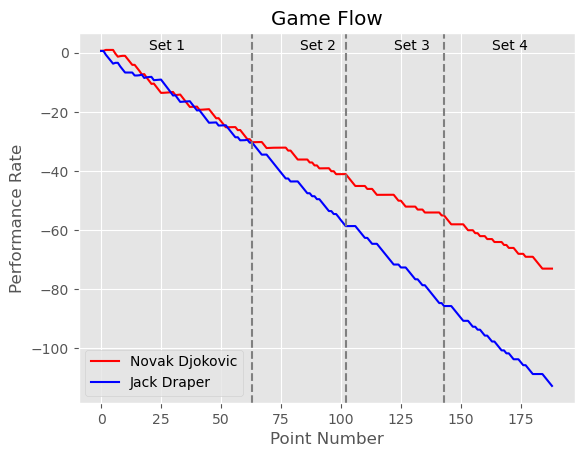

Novak Djokovic is winning going into set 3 with:  -41.03797030527232 momentum
Novak Djokovic is winning going into set 4 with:  -55.01654680998859 momentum
set 3 prediction is correct
set 4 prediction is correct


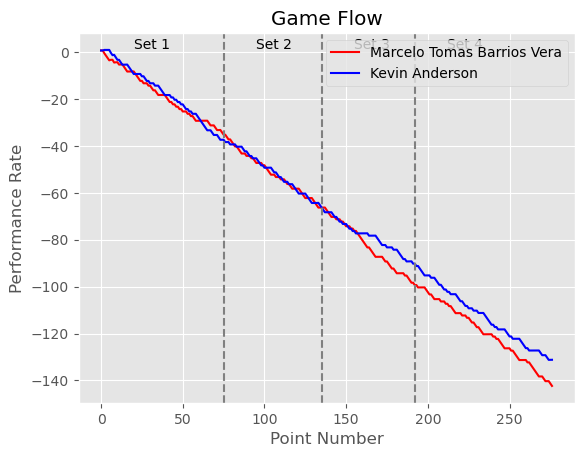

Marcelo Tomas Barrios Vera is winning going into set 3 with:  -66.27842717374061 momentum
Kevin Anderson is winning going into set 4 with:  -90.19961027121411 momentum
set 3 prediction is wrong
set 4 prediction is correct


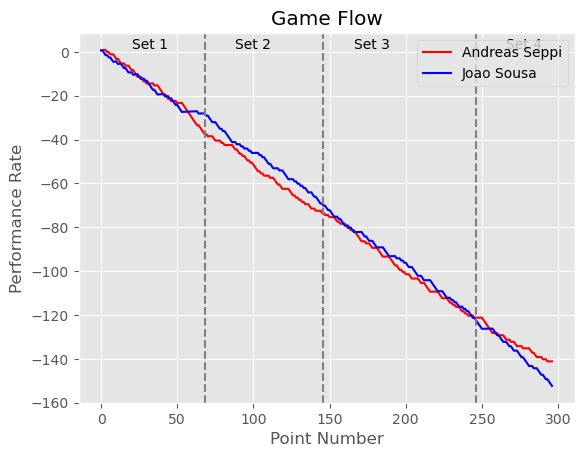

Joao Sousa is winning going into set 3 with:  -70.15052810508266 momentum
Andreas Seppi is winning going into set 4 with:  -121.23825589481186 momentum
set 3 prediction is wrong
set 4 prediction is correct


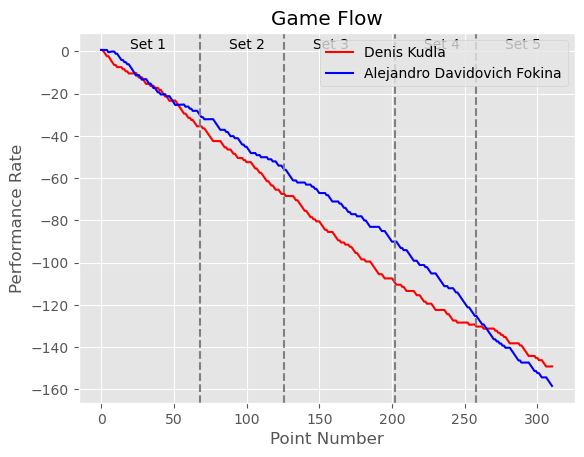

Alejandro Davidovich Fokina is winning going into set 3 with:  -56.0654486305806 momentum
Alejandro Davidovich Fokina is winning going into set 4 with:  -90.05391460520308 momentum
Alejandro Davidovich Fokina is winning going into set 5 with:  -125.19673528398963 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


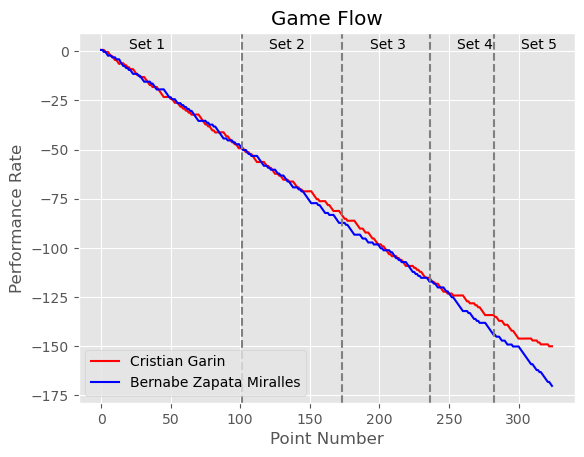

Cristian Garin is winning going into set 3 with:  -83.20579012560073 momentum
Cristian Garin is winning going into set 4 with:  -115.25909038153719 momentum
Cristian Garin is winning going into set 5 with:  -134.178475570706 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


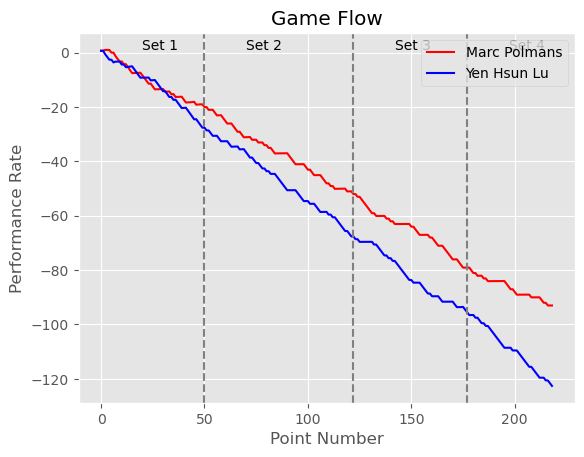

Marc Polmans is winning going into set 3 with:  -52.04083668878152 momentum
Marc Polmans is winning going into set 4 with:  -79.07957487012067 momentum
set 3 prediction is correct
set 4 prediction is correct


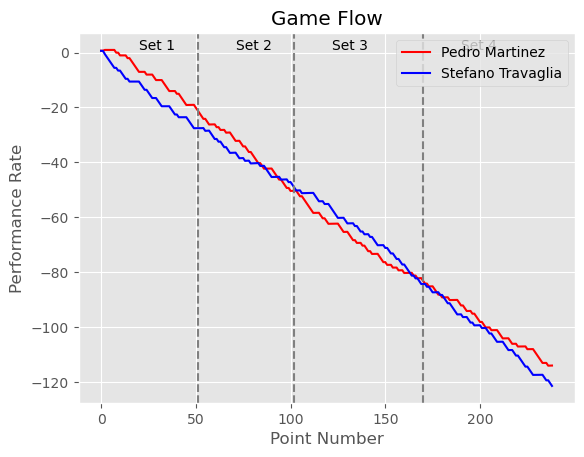

Stefano Travaglia is winning going into set 3 with:  -49.218160914374984 momentum
Pedro Martinez is winning going into set 4 with:  -83.21862956848662 momentum
set 3 prediction is wrong
set 4 prediction is correct


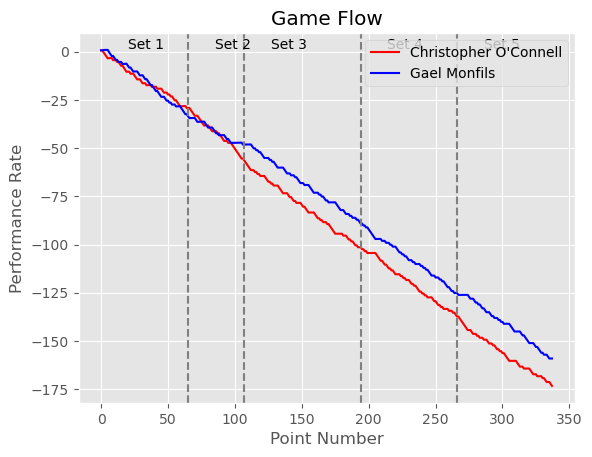

Gael Monfils is winning going into set 3 with:  -48.1212975965339 momentum
Gael Monfils is winning going into set 4 with:  -89.10078682637777 momentum
Gael Monfils is winning going into set 5 with:  -125.1118185591635 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


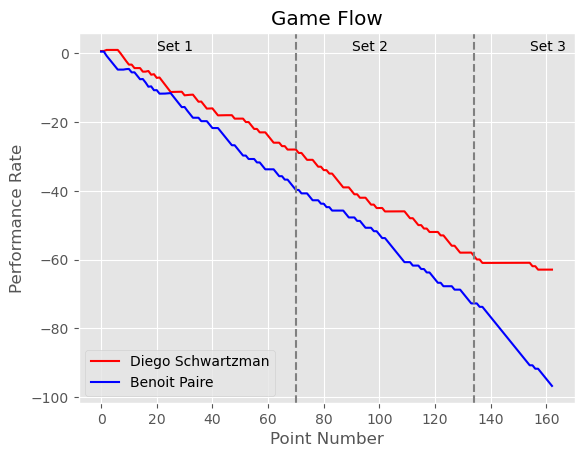

Diego Schwartzman is winning going into set 3 with:  -58.95084472710695 momentum
set 3 prediction is correct


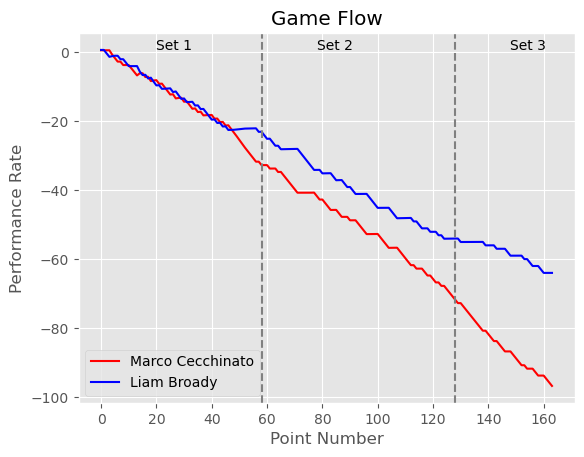

Liam Broady is winning going into set 3 with:  -54.011368424639166 momentum
set 3 prediction is correct


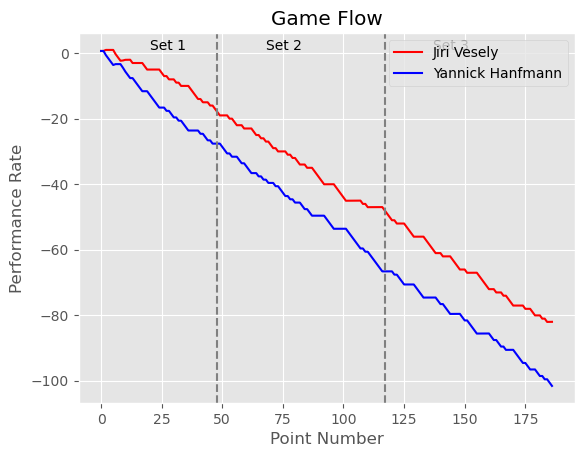

Jiri Vesely is winning going into set 3 with:  -48.043894146945654 momentum
set 3 prediction is correct


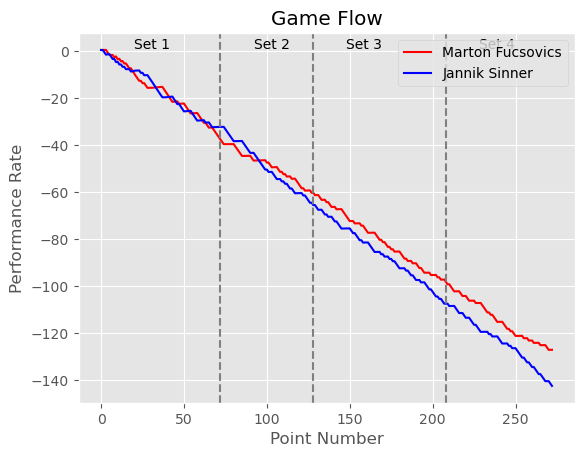

Marton Fucsovics is winning going into set 3 with:  -60.17024125624132 momentum
Marton Fucsovics is winning going into set 4 with:  -98.14568842654961 momentum
set 3 prediction is correct
set 4 prediction is correct


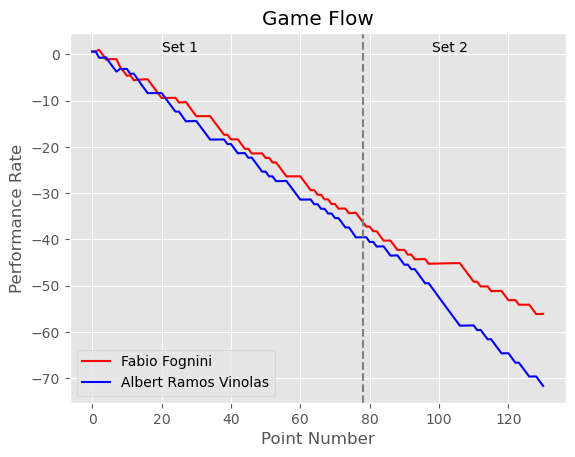

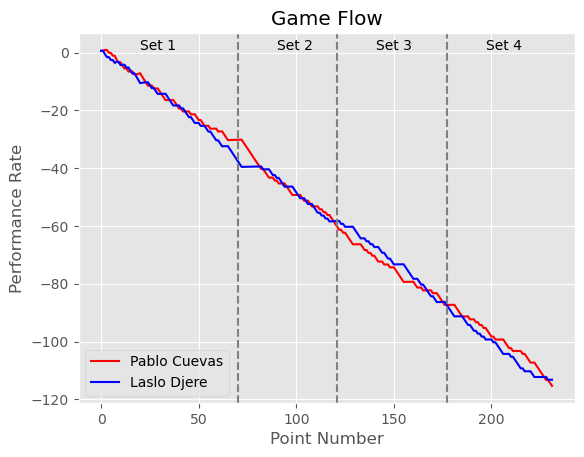

Laslo Djere is winning going into set 3 with:  -58.302113391710016 momentum
Laslo Djere is winning going into set 4 with:  -87.24805722783323 momentum
set 3 prediction is correct
set 4 prediction is correct


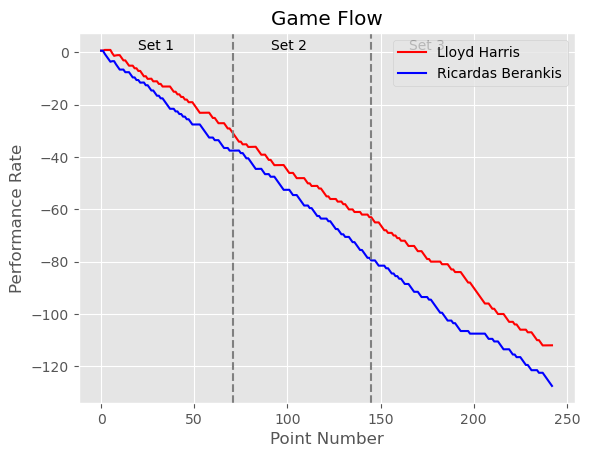

Lloyd Harris is winning going into set 3 with:  -63.027189831338994 momentum
set 3 prediction is correct


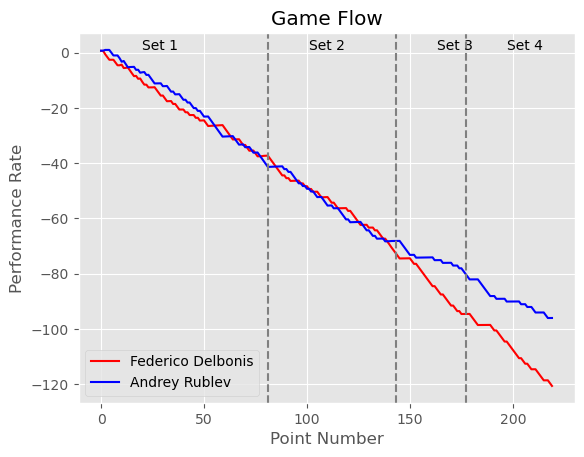

Andrey Rublev is winning going into set 3 with:  -68.15678942696142 momentum
Andrey Rublev is winning going into set 4 with:  -80.04980983900593 momentum
set 3 prediction is correct
set 4 prediction is correct


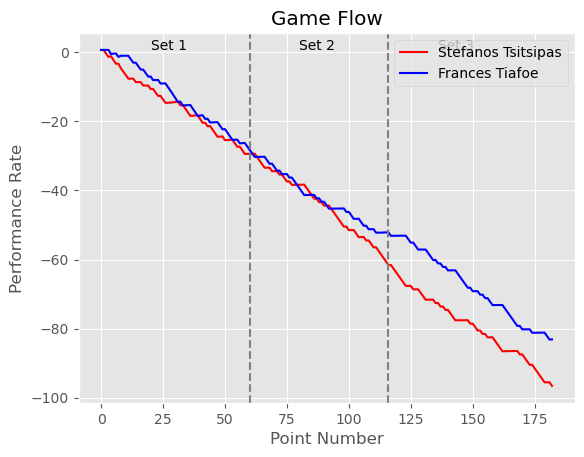

Frances Tiafoe is winning going into set 3 with:  -52.13623639728614 momentum
set 3 prediction is correct


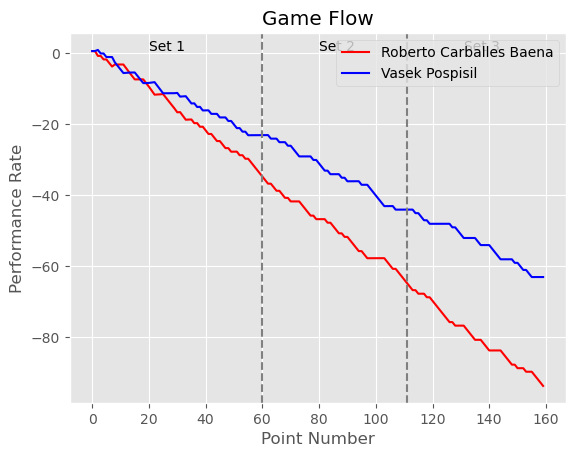

Vasek Pospisil is winning going into set 3 with:  -44.03063792601431 momentum
set 3 prediction is correct


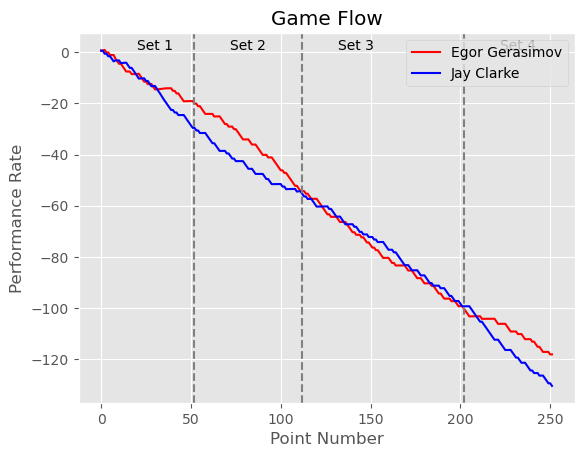

Egor Gerasimov is winning going into set 3 with:  -54.258263433918785 momentum
Jay Clarke is winning going into set 4 with:  -99.30349445291297 momentum
set 3 prediction is correct
set 4 prediction is wrong


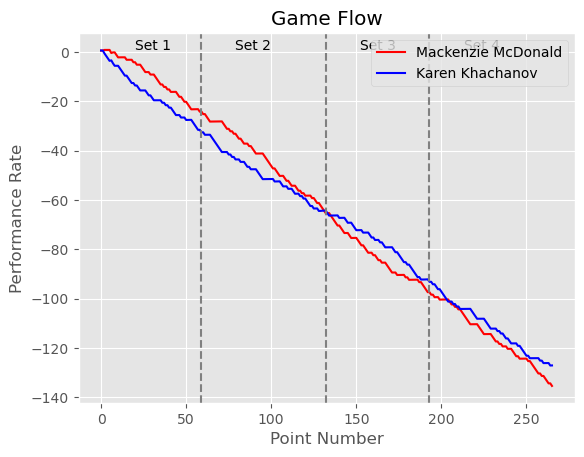

Karen Khachanov is winning going into set 3 with:  -64.2753053455521 momentum
Karen Khachanov is winning going into set 4 with:  -93.16977008868017 momentum
set 3 prediction is correct
set 4 prediction is correct


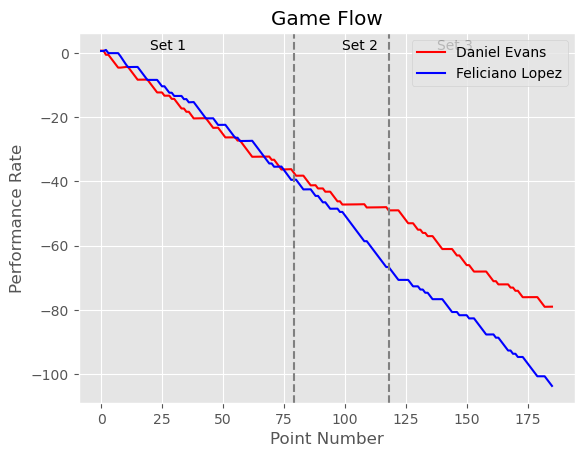

Daniel Evans is winning going into set 3 with:  -49.03204466418799 momentum
set 3 prediction is correct


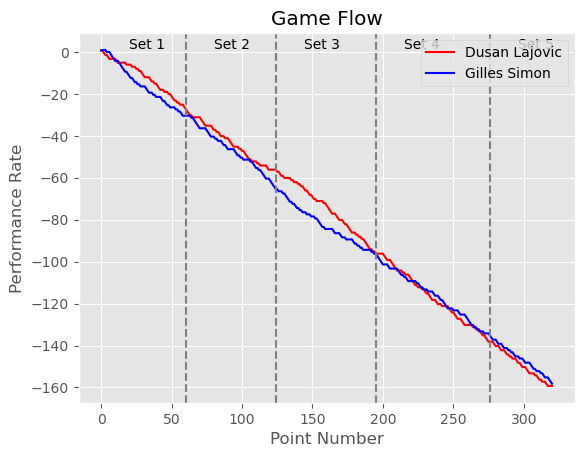

Dusan Lajovic is winning going into set 3 with:  -56.12074705841774 momentum
Dusan Lajovic is winning going into set 4 with:  -96.20129082067938 momentum
Gilles Simon is winning going into set 5 with:  -135.19573010841364 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


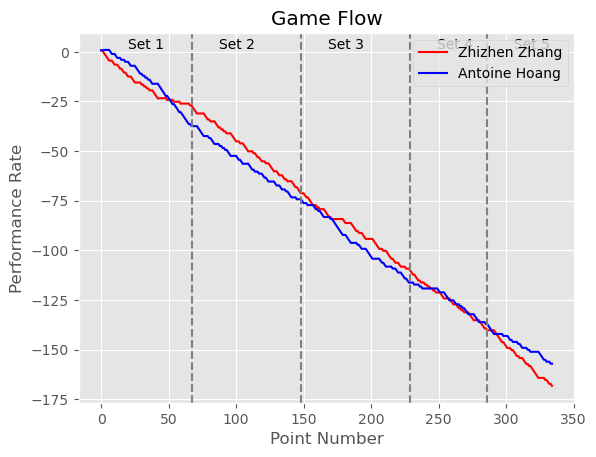

Zhizhen Zhang is winning going into set 3 with:  -71.26651944154612 momentum
Zhizhen Zhang is winning going into set 4 with:  -110.19946721202224 momentum
Antoine Hoang is winning going into set 5 with:  -137.1548698686813 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


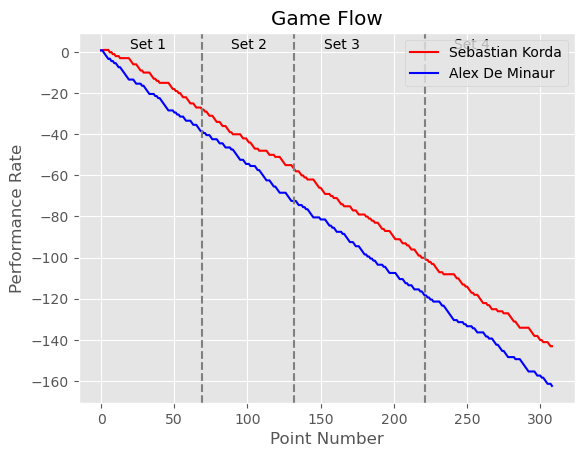

Sebastian Korda is winning going into set 3 with:  -57.071218538667736 momentum
Sebastian Korda is winning going into set 4 with:  -100.10722738861834 momentum
set 3 prediction is correct
set 4 prediction is correct


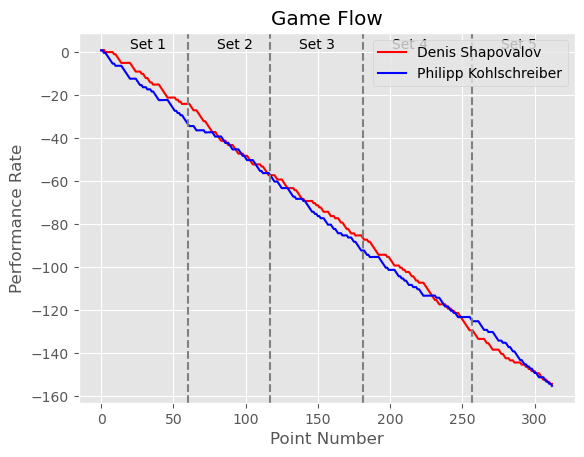

Philipp Kohlschreiber is winning going into set 3 with:  -57.2400759320122 momentum
Denis Shapovalov is winning going into set 4 with:  -86.24387812222221 momentum
Philipp Kohlschreiber is winning going into set 5 with:  -125.13291425233854 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is wrong


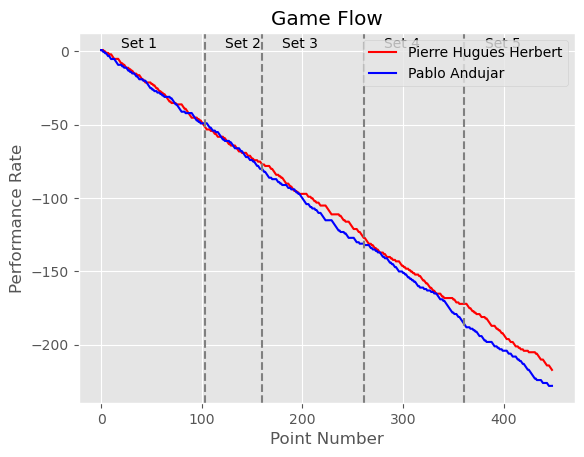

Pierre Hugues Herbert is winning going into set 3 with:  -77.24426347508548 momentum
Pierre Hugues Herbert is winning going into set 4 with:  -127.23842800847235 momentum
Pierre Hugues Herbert is winning going into set 5 with:  -172.16548779981602 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


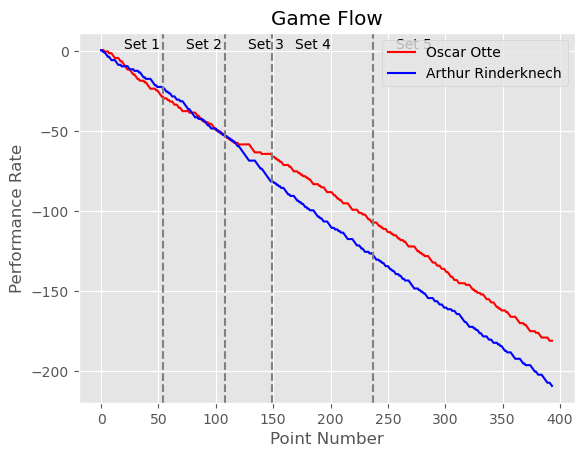

Arthur Rinderknech is winning going into set 3 with:  -52.226278326007396 momentum
Oscar Otte is winning going into set 4 with:  -65.06600082602515 momentum
Oscar Otte is winning going into set 5 with:  -107.06972904840106 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is wrong


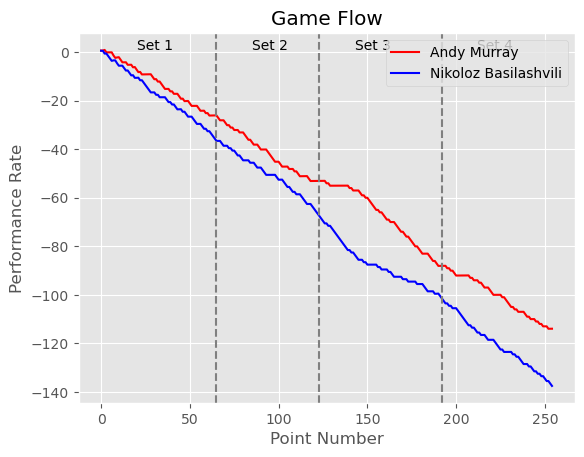

Andy Murray is winning going into set 3 with:  -53.04567548272809 momentum
Andy Murray is winning going into set 4 with:  -88.06723440488017 momentum
set 3 prediction is correct
set 4 prediction is correct


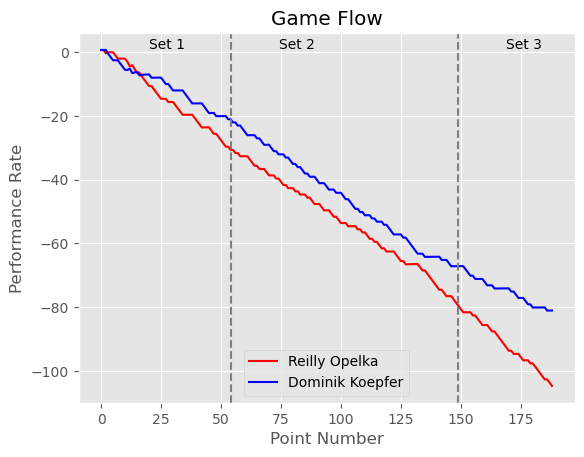

Dominik Koepfer is winning going into set 3 with:  -67.12570297849352 momentum
set 3 prediction is correct


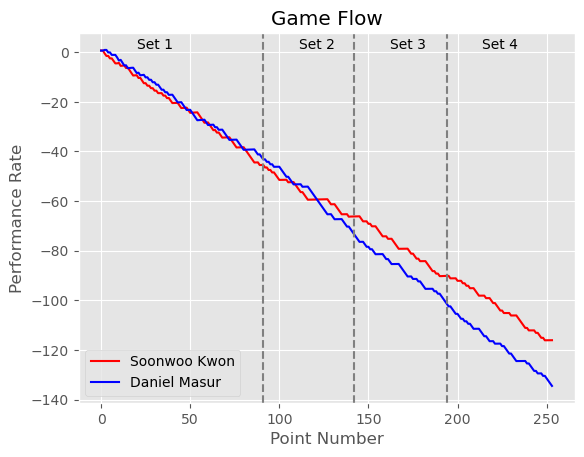

Soonwoo Kwon is winning going into set 3 with:  -66.19239843626033 momentum
Soonwoo Kwon is winning going into set 4 with:  -90.15305047730138 momentum
set 3 prediction is correct
set 4 prediction is correct


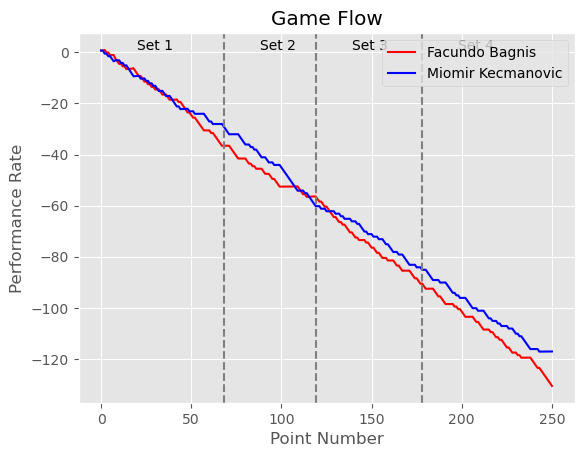

Facundo Bagnis is winning going into set 3 with:  -56.38470585960685 momentum
Miomir Kecmanovic is winning going into set 4 with:  -85.09588642747951 momentum
set 3 prediction is wrong
set 4 prediction is correct


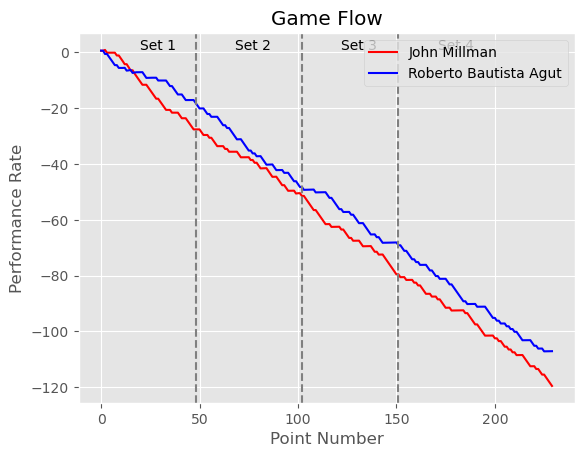

Roberto Bautista Agut is winning going into set 3 with:  -48.211198538963075 momentum
Roberto Bautista Agut is winning going into set 4 with:  -69.1085455713467 momentum
set 3 prediction is correct
set 4 prediction is correct


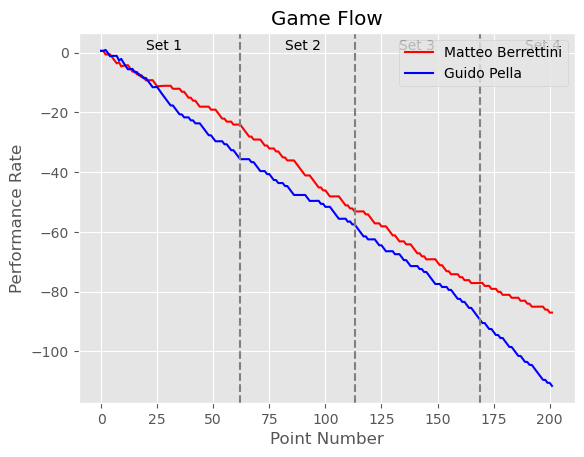

Matteo Berrettini is winning going into set 3 with:  -53.16434603853824 momentum
Matteo Berrettini is winning going into set 4 with:  -77.10094690324632 momentum
set 3 prediction is correct
set 4 prediction is correct


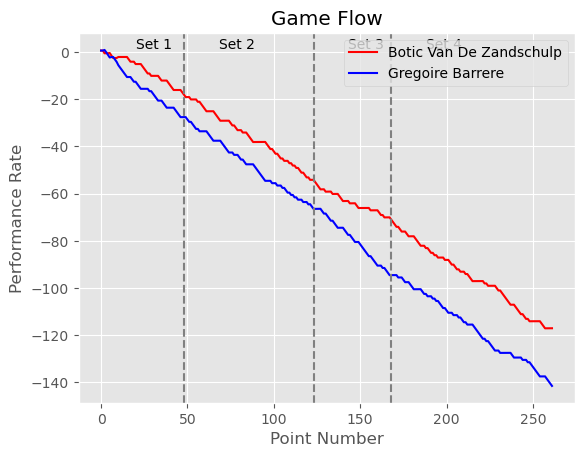

Botic Van De Zandschulp is winning going into set 3 with:  -54.1343481708416 momentum
Botic Van De Zandschulp is winning going into set 4 with:  -71.04718826794486 momentum
set 3 prediction is correct
set 4 prediction is correct


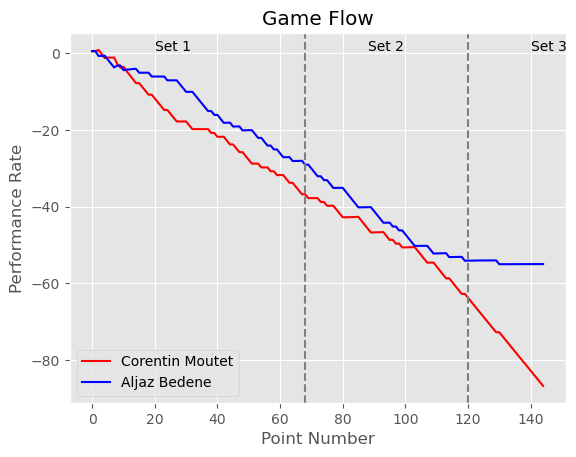

Aljaz Bedene is winning going into set 3 with:  -54.07260799557743 momentum
set 3 prediction is correct


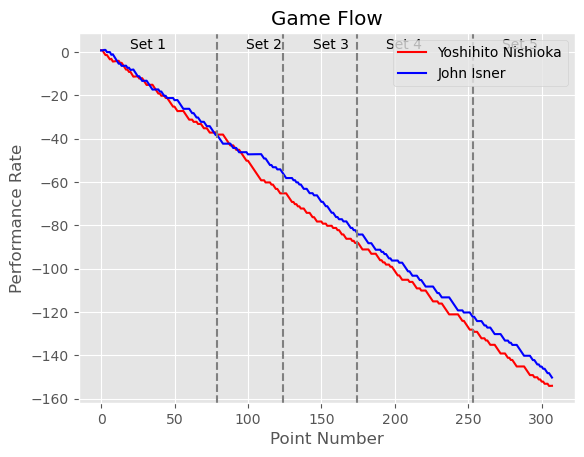

John Isner is winning going into set 3 with:  -56.22732519371644 momentum
John Isner is winning going into set 4 with:  -83.2945162701207 momentum
John Isner is winning going into set 5 with:  -122.25427590363687 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


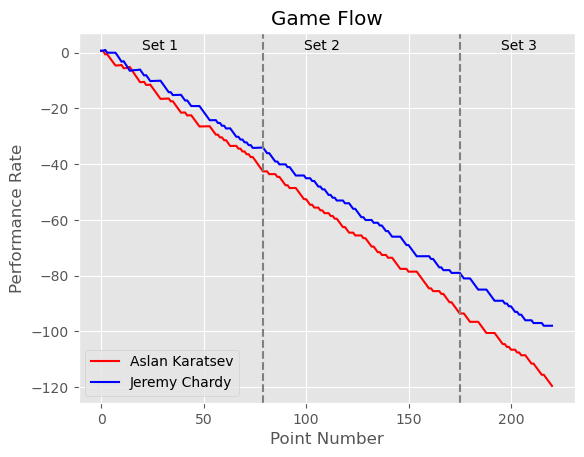

Jeremy Chardy is winning going into set 3 with:  -79.03481287874799 momentum
set 3 prediction is correct


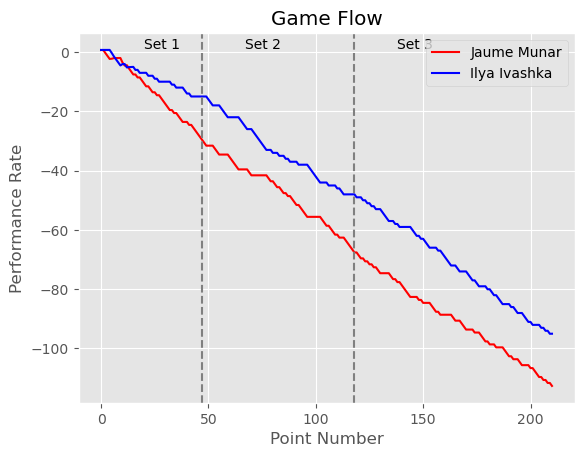

Ilya Ivashka is winning going into set 3 with:  -48.02979840048965 momentum
set 3 prediction is correct


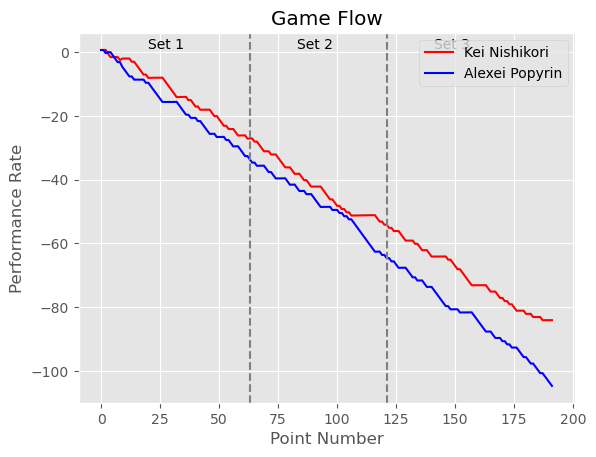

Kei Nishikori is winning going into set 3 with:  -54.11482189395399 momentum
set 3 prediction is correct


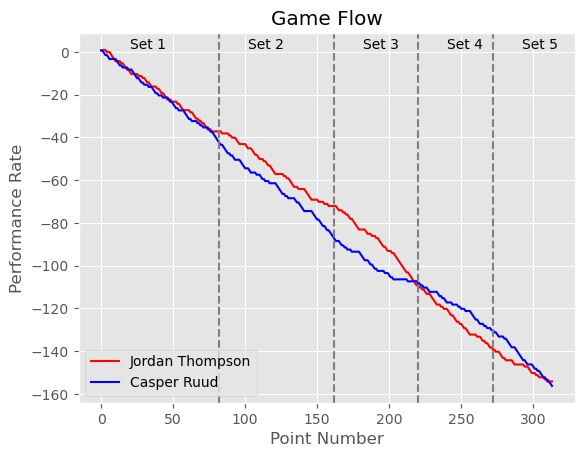

Jordan Thompson is winning going into set 3 with:  -72.08652735379754 momentum
Casper Ruud is winning going into set 4 with:  -108.28120867757164 momentum
Casper Ruud is winning going into set 5 with:  -130.1769681352679 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is wrong


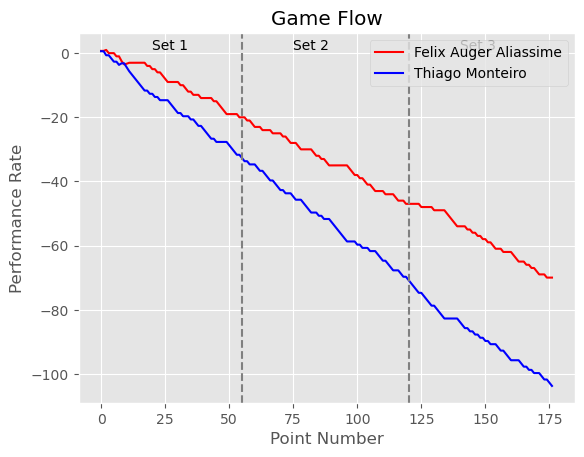

Felix Auger Aliassime is winning going into set 3 with:  -46.98594490750118 momentum
set 3 prediction is correct


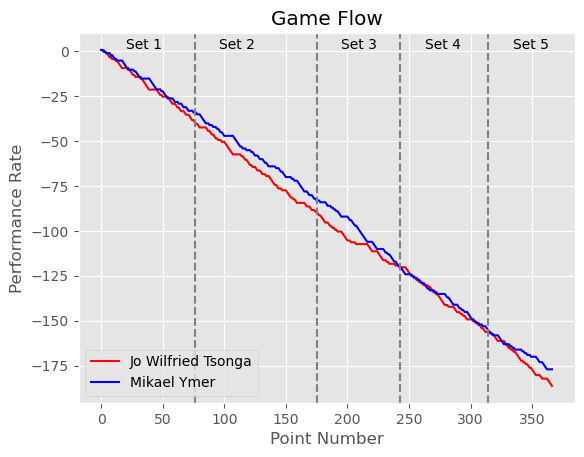

Mikael Ymer is winning going into set 3 with:  -83.08395908627644 momentum
Mikael Ymer is winning going into set 4 with:  -120.12802516976093 momentum
Mikael Ymer is winning going into set 5 with:  -155.09732326055536 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


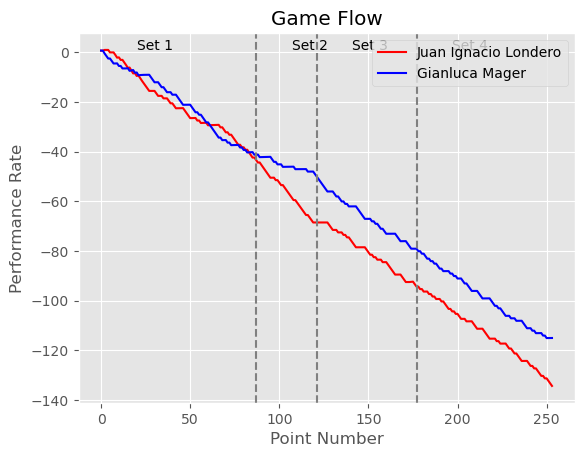

Gianluca Mager is winning going into set 3 with:  -50.053314152856544 momentum
Gianluca Mager is winning going into set 4 with:  -79.12834438885871 momentum
set 3 prediction is correct
set 4 prediction is correct


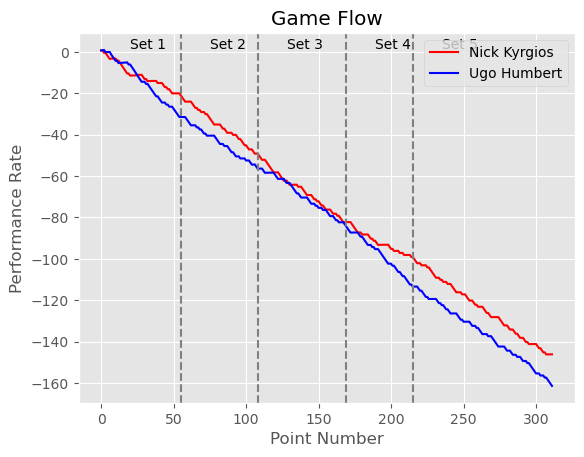

Nick Kyrgios is winning going into set 3 with:  -49.131571245348205 momentum
Nick Kyrgios is winning going into set 4 with:  -82.22139687527942 momentum
Nick Kyrgios is winning going into set 5 with:  -99.08022862960061 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


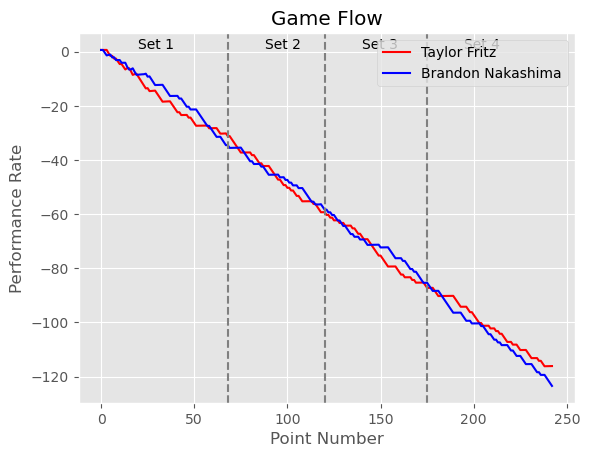

Brandon Nakashima is winning going into set 3 with:  -58.334254483860526 momentum
Brandon Nakashima is winning going into set 4 with:  -85.33578913072367 momentum
set 3 prediction is wrong
set 4 prediction is wrong


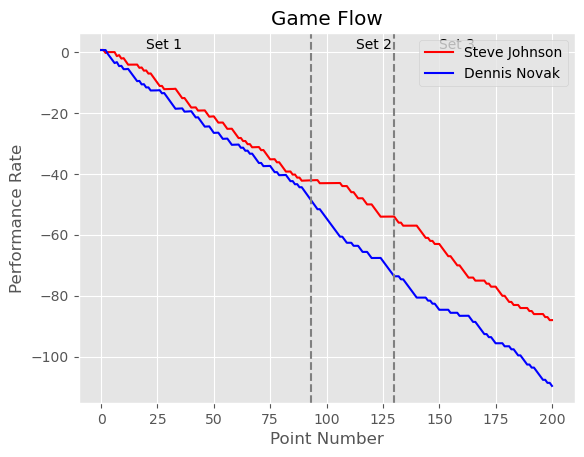

Steve Johnson is winning going into set 3 with:  -54.03084690859492 momentum
set 3 prediction is correct


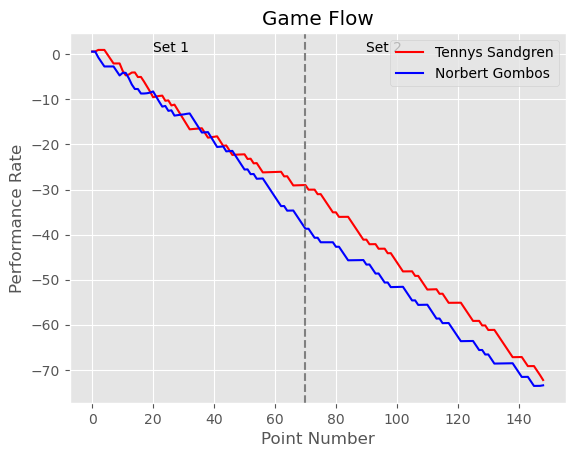

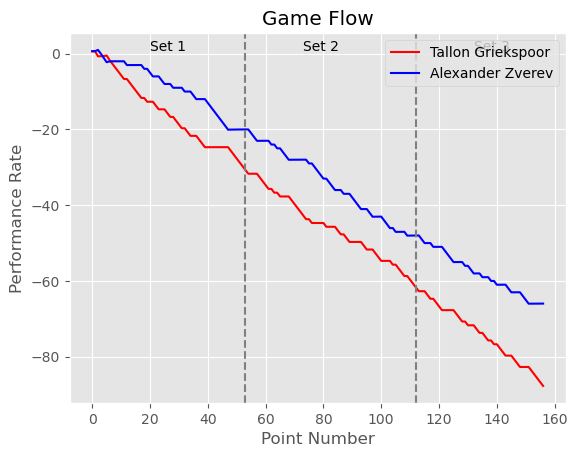

Alexander Zverev is winning going into set 3 with:  -48.017588108572355 momentum
set 3 prediction is correct


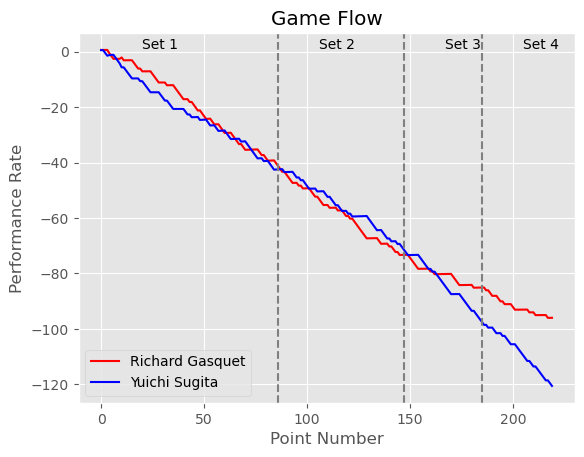

Yuichi Sugita is winning going into set 3 with:  -71.33808318666091 momentum
Richard Gasquet is winning going into set 4 with:  -85.07235647904153 momentum
set 3 prediction is correct
set 4 prediction is wrong


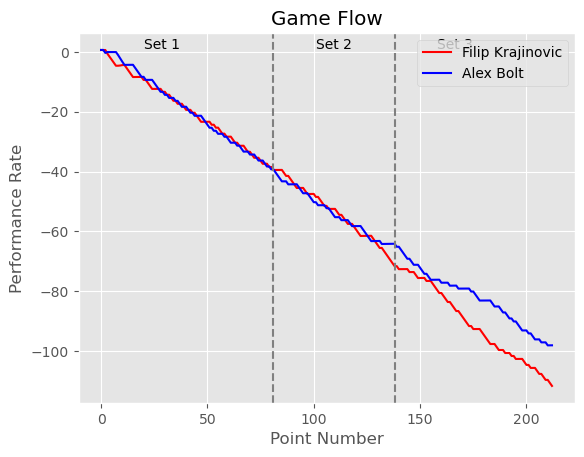

Alex Bolt is winning going into set 3 with:  -64.10487934923766 momentum
set 3 prediction is correct


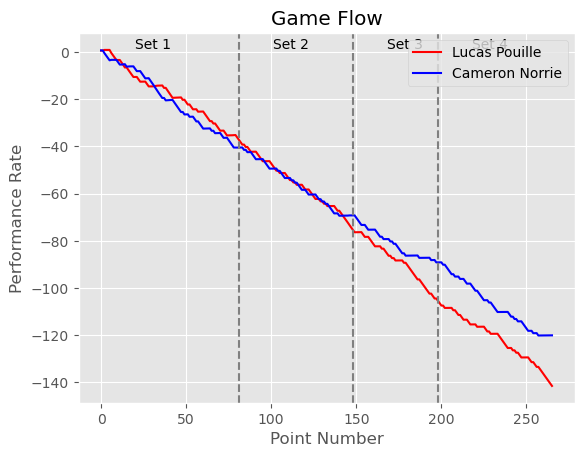

Cameron Norrie is winning going into set 3 with:  -69.20277837309013 momentum
Cameron Norrie is winning going into set 4 with:  -89.10709140485048 momentum
set 3 prediction is correct
set 4 prediction is correct


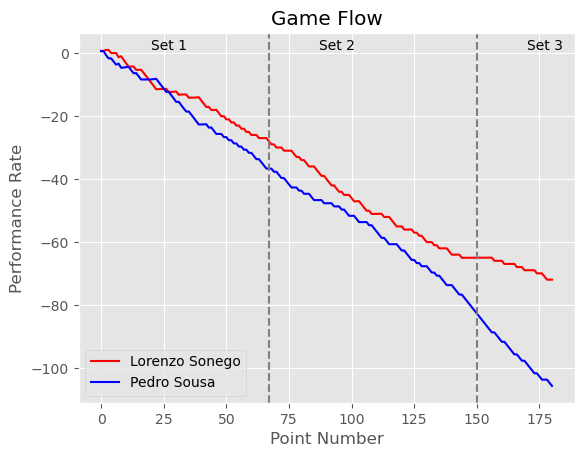

Lorenzo Sonego is winning going into set 3 with:  -64.98637124875754 momentum
set 3 prediction is correct


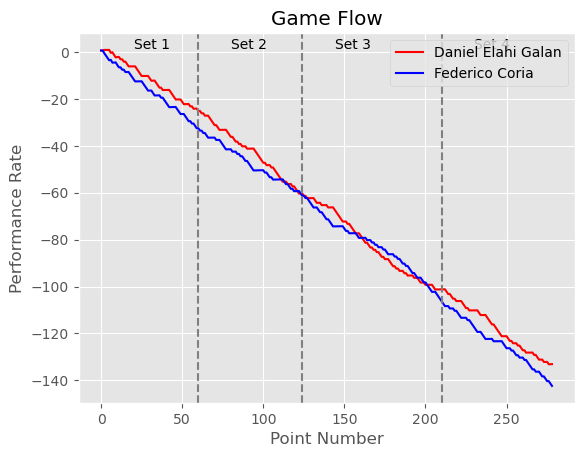

Daniel Elahi Galan is winning going into set 3 with:  -60.31920808959306 momentum
Daniel Elahi Galan is winning going into set 4 with:  -101.18796422706102 momentum
set 3 prediction is correct
set 4 prediction is correct


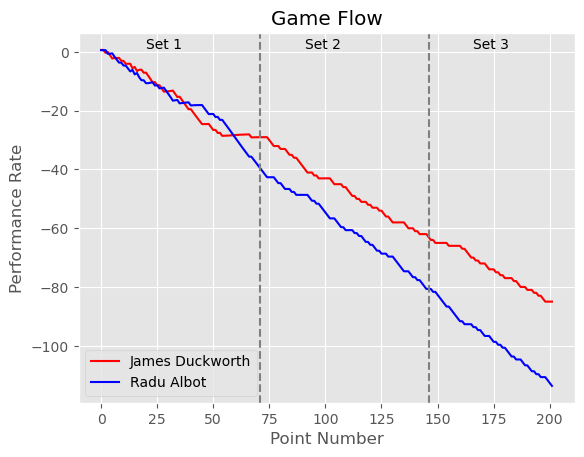

James Duckworth is winning going into set 3 with:  -62.99733649527504 momentum
set 3 prediction is correct


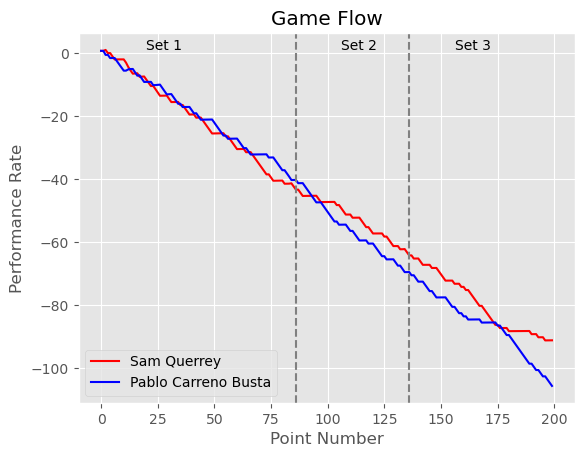

Sam Querrey is winning going into set 3 with:  -64.19612922467303 momentum
set 3 prediction is correct


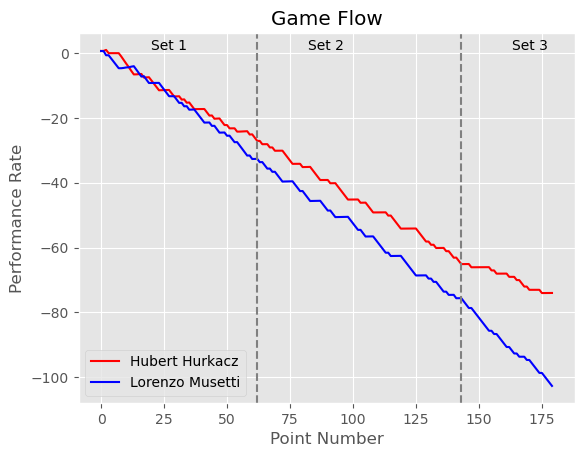

Hubert Hurkacz is winning going into set 3 with:  -65.11557650459555 momentum
set 3 prediction is correct


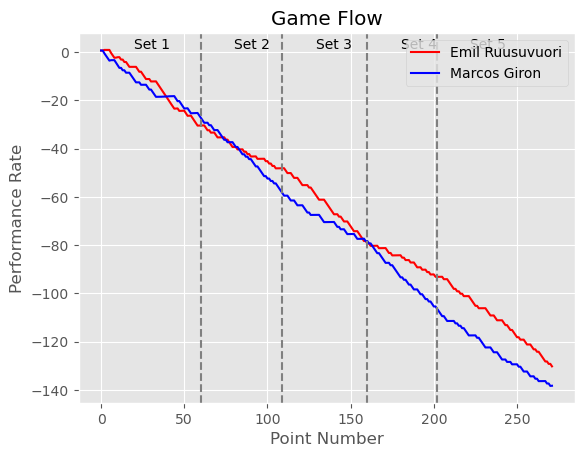

Emil Ruusuvuori is winning going into set 3 with:  -48.10311265366203 momentum
Marcos Giron is winning going into set 4 with:  -78.26913994626452 momentum
Emil Ruusuvuori is winning going into set 5 with:  -93.09723214128417 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is wrong


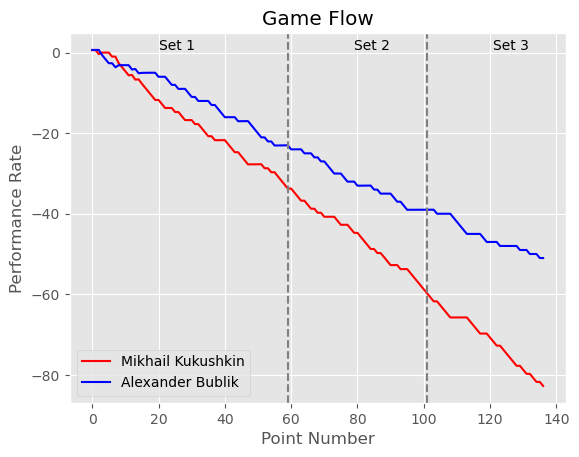

Alexander Bublik is winning going into set 3 with:  -39.02431658749436 momentum
set 3 prediction is correct


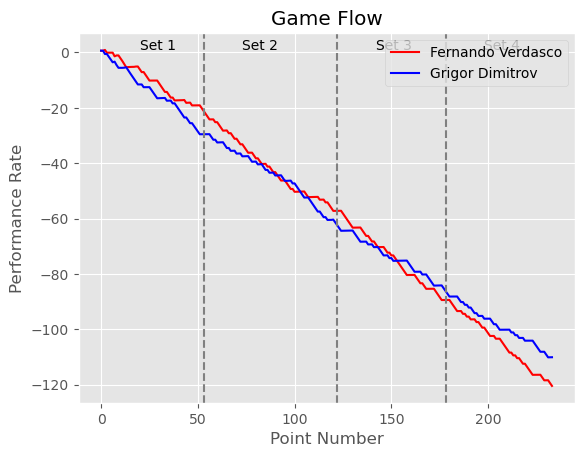

Fernando Verdasco is winning going into set 3 with:  -57.20522246018844 momentum
Grigor Dimitrov is winning going into set 4 with:  -86.16720634388858 momentum
set 3 prediction is wrong
set 4 prediction is correct


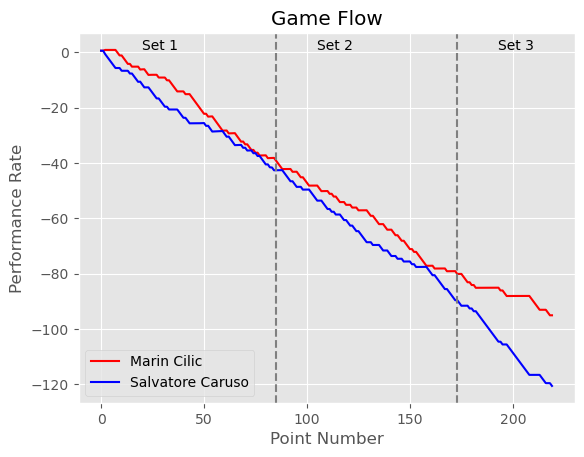

Marin Cilic is winning going into set 3 with:  -80.08661732314125 momentum
set 3 prediction is correct


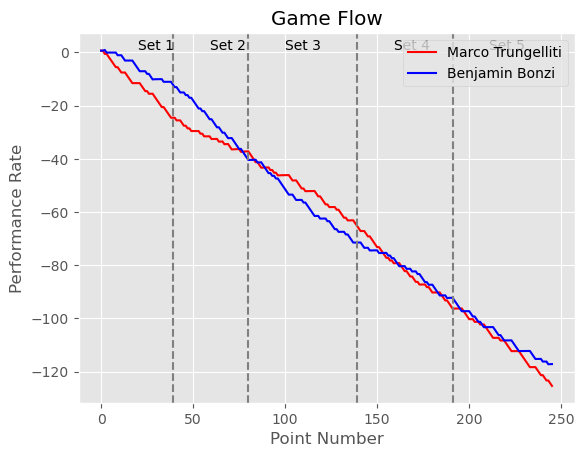

Marco Trungelliti is winning going into set 3 with:  -37.182250885062224 momentum
Marco Trungelliti is winning going into set 4 with:  -65.12677815628942 momentum
Benjamin Bonzi is winning going into set 5 with:  -92.23373636321156 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


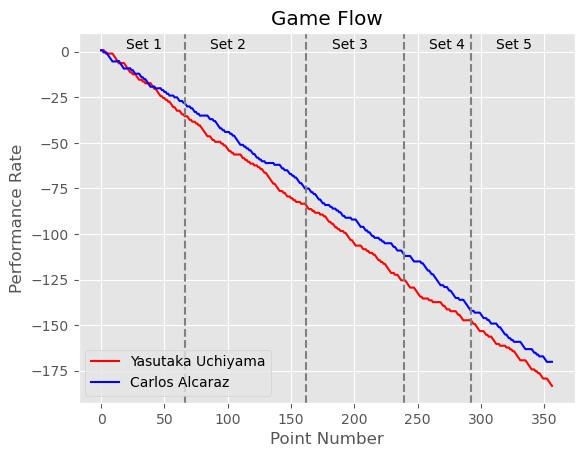

Carlos Alcaraz is winning going into set 3 with:  -75.10308845054315 momentum
Carlos Alcaraz is winning going into set 4 with:  -111.06272222620986 momentum
Carlos Alcaraz is winning going into set 5 with:  -142.14113840997283 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


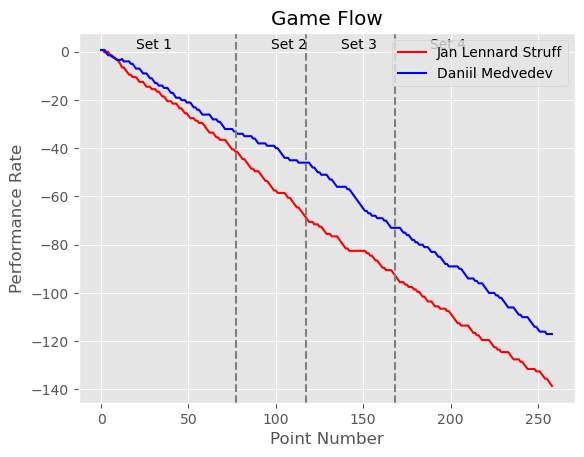

Daniil Medvedev is winning going into set 3 with:  -46.00912226663608 momentum
Daniil Medvedev is winning going into set 4 with:  -73.0200723789258 momentum
set 3 prediction is correct
set 4 prediction is correct


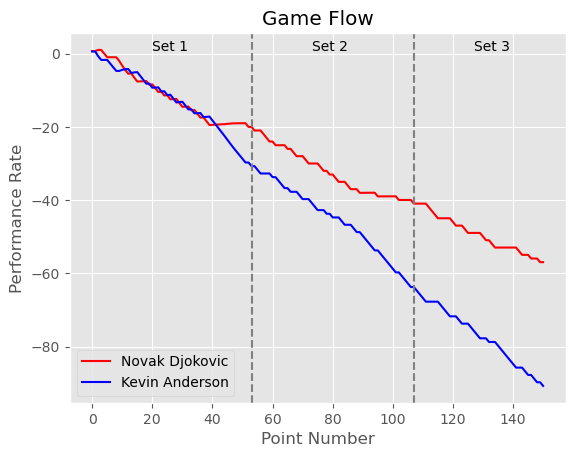

Novak Djokovic is winning going into set 3 with:  -40.974307139784784 momentum
set 3 prediction is correct


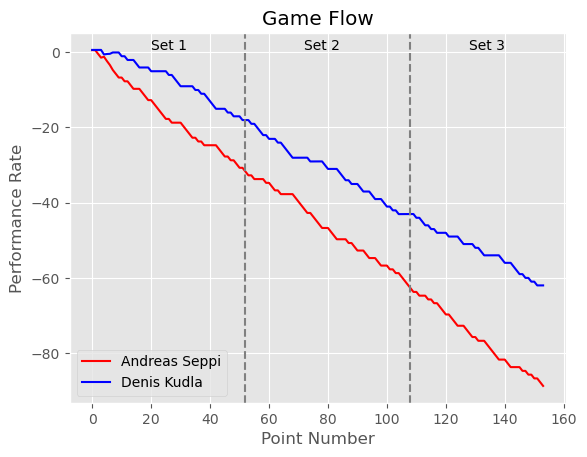

Denis Kudla is winning going into set 3 with:  -43.02603867405758 momentum
set 3 prediction is correct


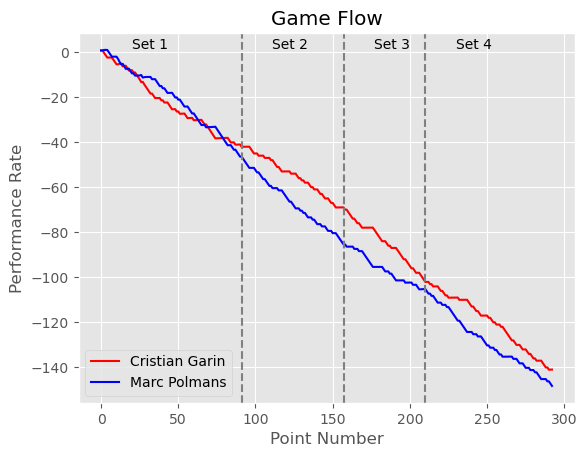

Cristian Garin is winning going into set 3 with:  -69.04159916014127 momentum
Cristian Garin is winning going into set 4 with:  -102.17006730160944 momentum
set 3 prediction is correct
set 4 prediction is correct


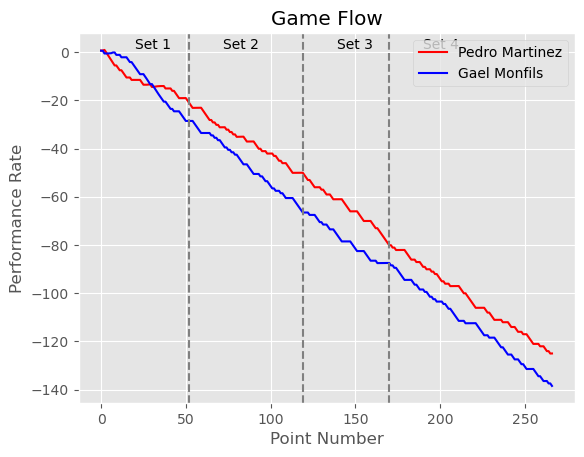

Pedro Martinez is winning going into set 3 with:  -50.03270122928078 momentum
Pedro Martinez is winning going into set 4 with:  -80.1129259394625 momentum
set 3 prediction is correct
set 4 prediction is correct


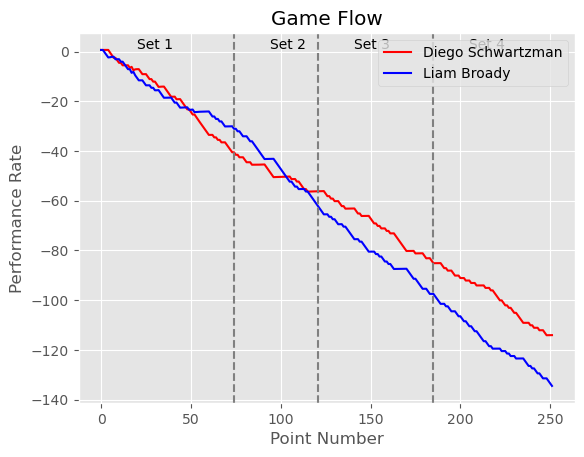

Diego Schwartzman is winning going into set 3 with:  -56.1603396356007 momentum
Diego Schwartzman is winning going into set 4 with:  -85.12317888487536 momentum
set 3 prediction is correct
set 4 prediction is correct


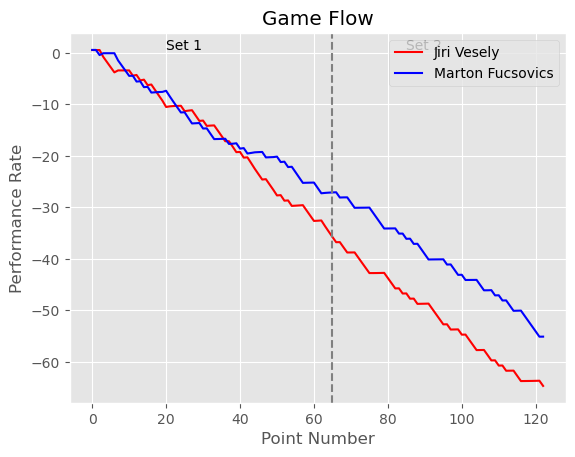

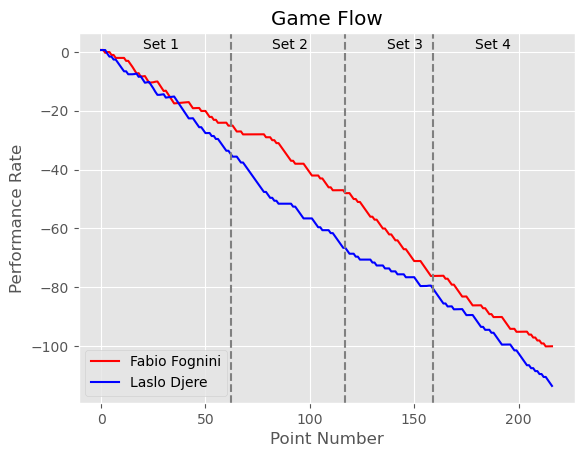

Fabio Fognini is winning going into set 3 with:  -48.02088867403835 momentum
Fabio Fognini is winning going into set 4 with:  -76.16195293450994 momentum
set 3 prediction is correct
set 4 prediction is correct


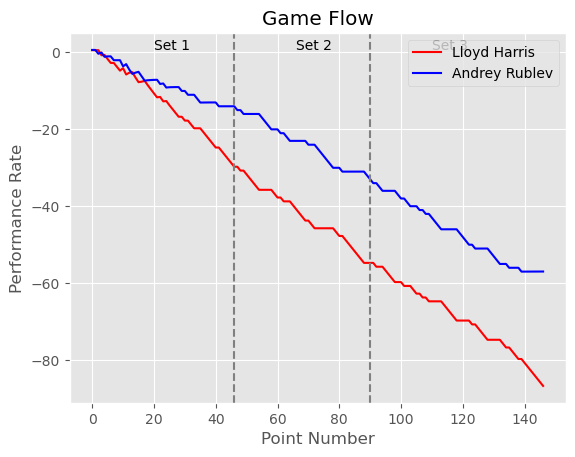

Andrey Rublev is winning going into set 3 with:  -33.00946175229835 momentum
set 3 prediction is correct


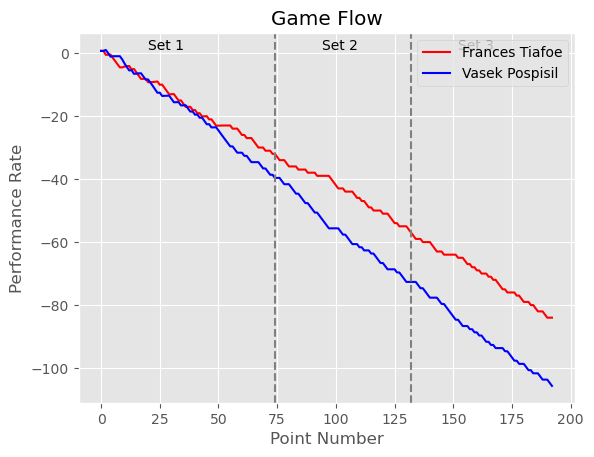

Frances Tiafoe is winning going into set 3 with:  -57.0087851962068 momentum
set 3 prediction is correct


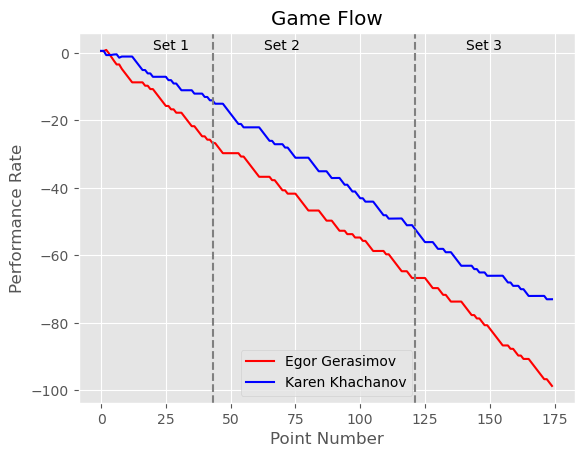

Karen Khachanov is winning going into set 3 with:  -52.03350697084548 momentum
set 3 prediction is correct


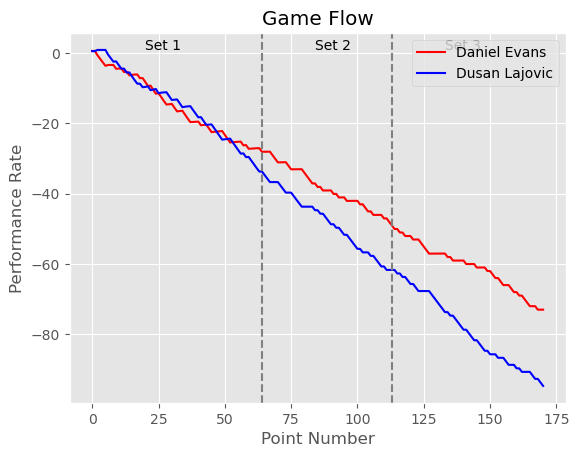

Daniel Evans is winning going into set 3 with:  -49.03426314275601 momentum
set 3 prediction is correct


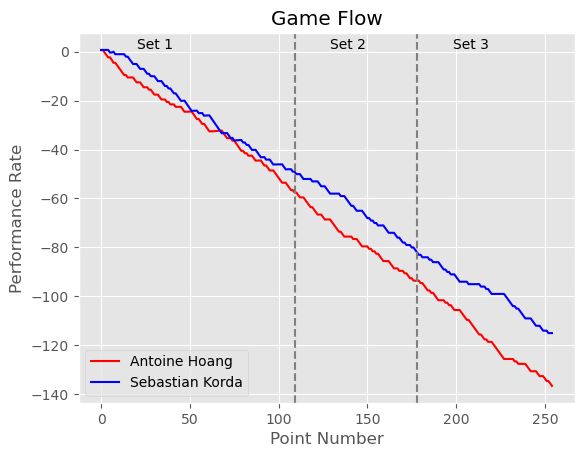

Sebastian Korda is winning going into set 3 with:  -82.00645025226471 momentum
set 3 prediction is correct


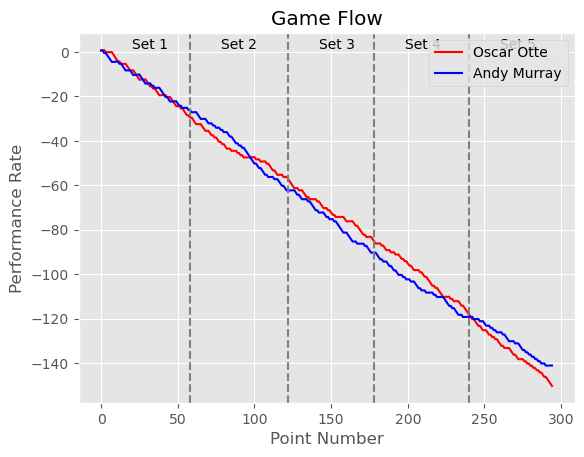

Oscar Otte is winning going into set 3 with:  -57.215858676665015 momentum
Oscar Otte is winning going into set 4 with:  -85.21439718909595 momentum
Oscar Otte is winning going into set 5 with:  -118.24904232031926 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


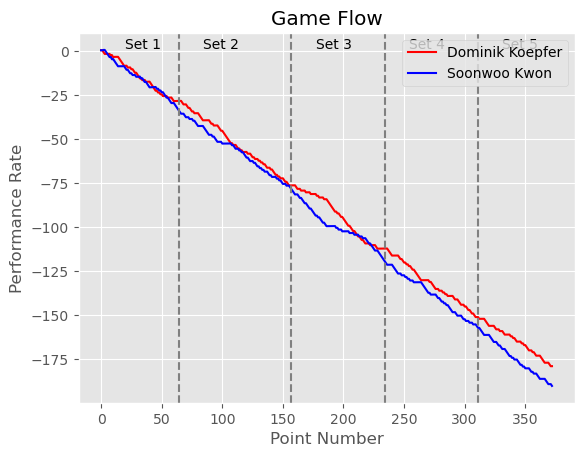

Dominik Koepfer is winning going into set 3 with:  -76.19503448655955 momentum
Dominik Koepfer is winning going into set 4 with:  -112.11661429684327 momentum
Dominik Koepfer is winning going into set 5 with:  -151.12768120346908 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


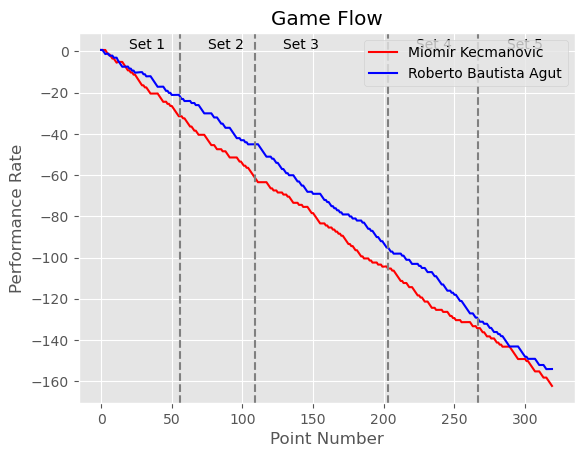

Roberto Bautista Agut is winning going into set 3 with:  -45.04862461449133 momentum
Roberto Bautista Agut is winning going into set 4 with:  -95.13032598205754 momentum
Roberto Bautista Agut is winning going into set 5 with:  -130.15879628063038 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


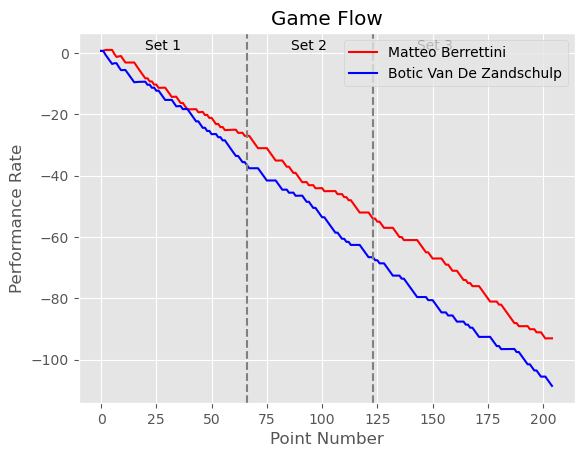

Matteo Berrettini is winning going into set 3 with:  -54.059193245043986 momentum
set 3 prediction is correct


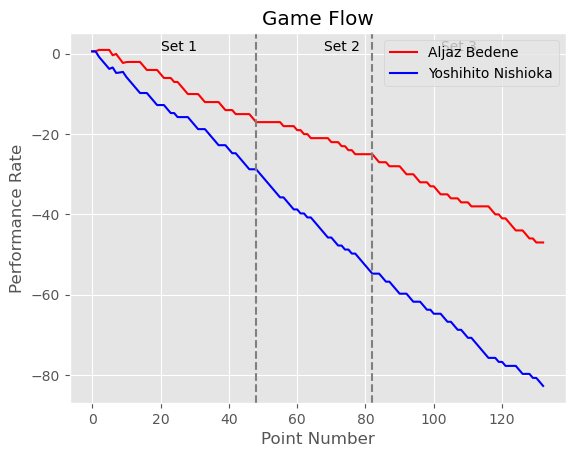

Aljaz Bedene is winning going into set 3 with:  -25.030102861607205 momentum
set 3 prediction is correct


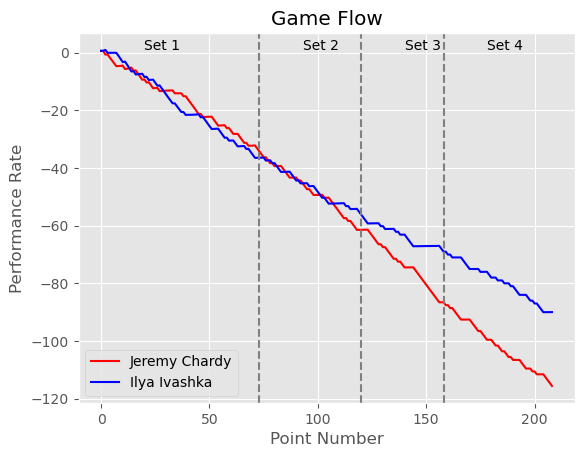

Ilya Ivashka is winning going into set 3 with:  -56.18994341126429 momentum
Ilya Ivashka is winning going into set 4 with:  -69.0468856378708 momentum
set 3 prediction is correct
set 4 prediction is correct


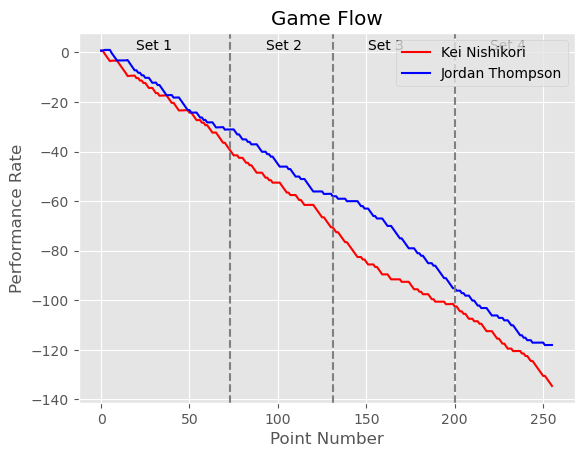

Jordan Thompson is winning going into set 3 with:  -58.05789768381247 momentum
Jordan Thompson is winning going into set 4 with:  -95.11397095419943 momentum
set 3 prediction is correct
set 4 prediction is correct


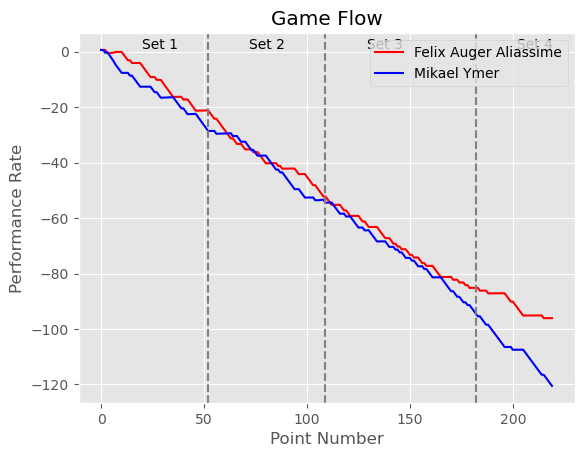

Felix Auger Aliassime is winning going into set 3 with:  -52.20114508263211 momentum
Felix Auger Aliassime is winning going into set 4 with:  -85.16870474713134 momentum
set 3 prediction is correct
set 4 prediction is correct


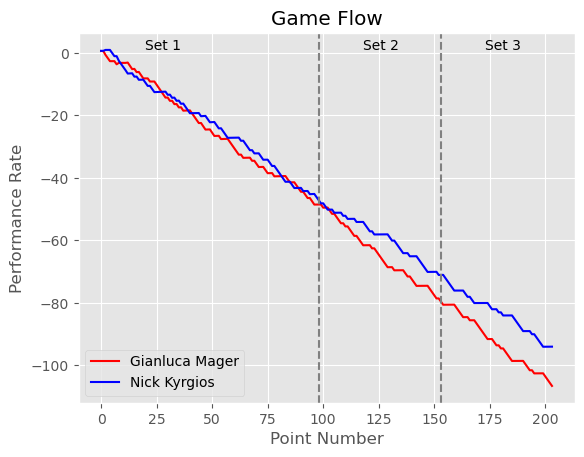

Nick Kyrgios is winning going into set 3 with:  -71.07074092407193 momentum
set 3 prediction is correct


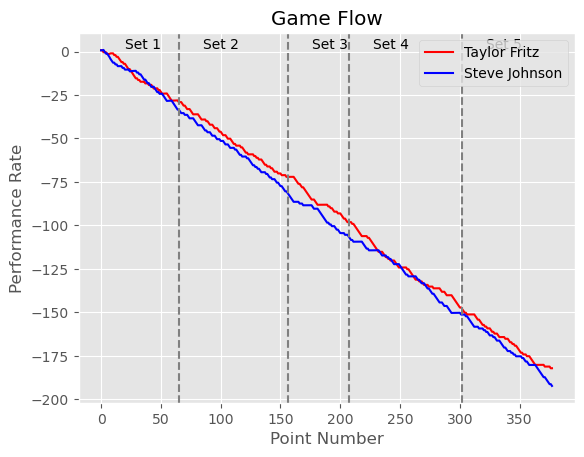

Taylor Fritz is winning going into set 3 with:  -72.06544565458397 momentum
Taylor Fritz is winning going into set 4 with:  -98.0991562106096 momentum
Taylor Fritz is winning going into set 5 with:  -148.169714413218 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


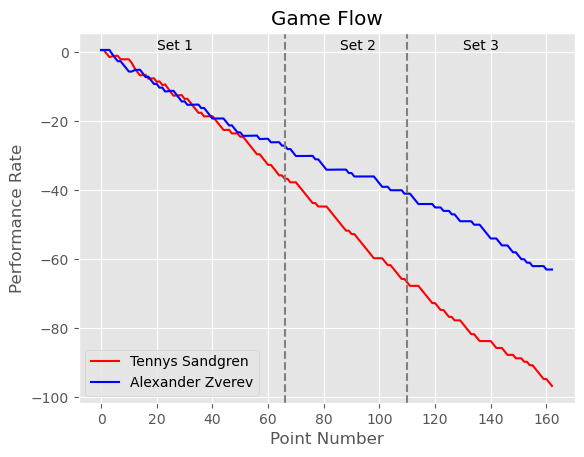

Alexander Zverev is winning going into set 3 with:  -41.00920355060148 momentum
set 3 prediction is correct


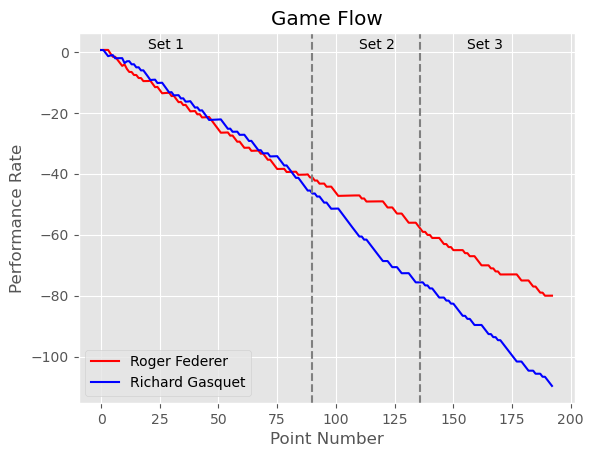

Roger Federer is winning going into set 3 with:  -58.07725459051585 momentum
set 3 prediction is correct


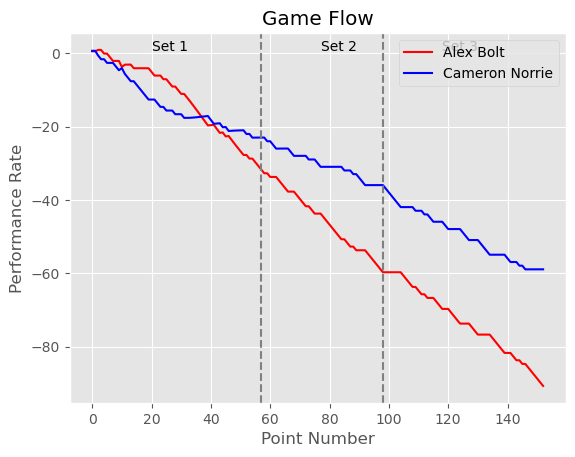

Cameron Norrie is winning going into set 3 with:  -35.969102138736226 momentum
set 3 prediction is correct


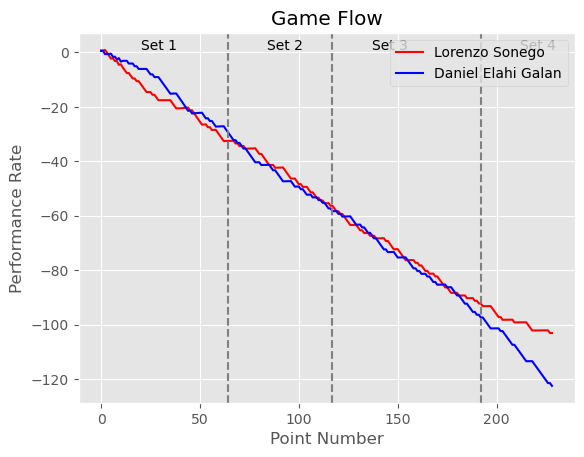

Lorenzo Sonego is winning going into set 3 with:  -56.30741401092874 momentum
Lorenzo Sonego is winning going into set 4 with:  -92.20600102571944 momentum
set 3 prediction is correct
set 4 prediction is correct


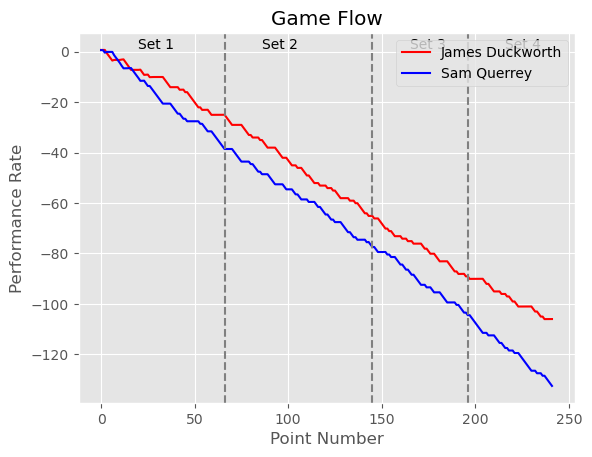

James Duckworth is winning going into set 3 with:  -65.12606382067392 momentum
James Duckworth is winning going into set 4 with:  -89.0992184527819 momentum
set 3 prediction is correct
set 4 prediction is correct


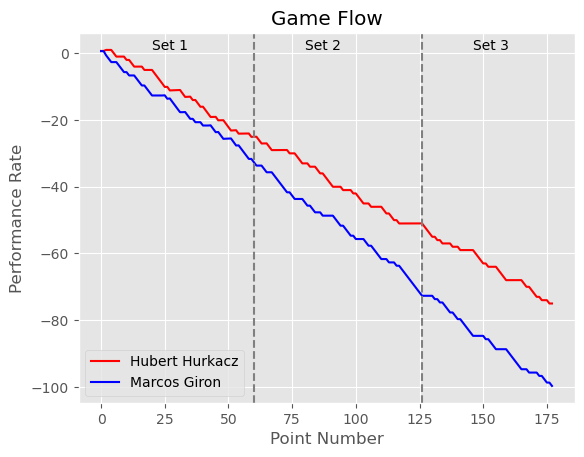

Hubert Hurkacz is winning going into set 3 with:  -51.004718227105386 momentum
set 3 prediction is correct


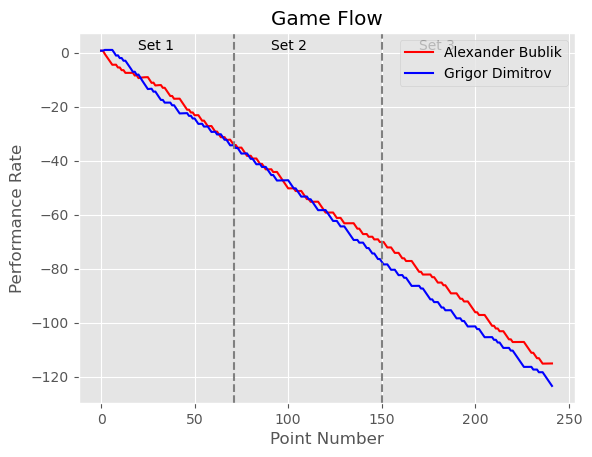

Alexander Bublik is winning going into set 3 with:  -70.16617042306731 momentum
set 3 prediction is correct


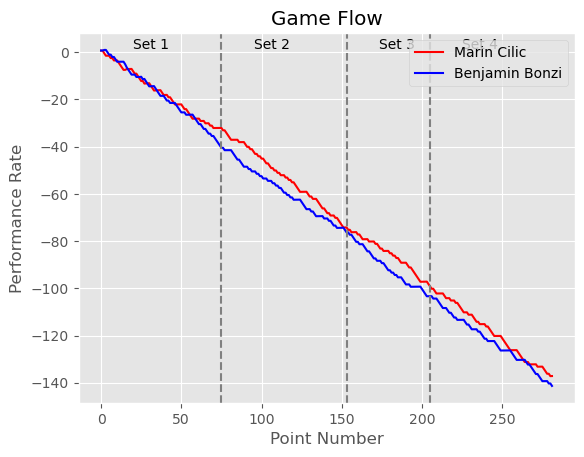

Marin Cilic is winning going into set 3 with:  -74.22300917350685 momentum
Marin Cilic is winning going into set 4 with:  -99.18334190904605 momentum
set 3 prediction is correct
set 4 prediction is correct


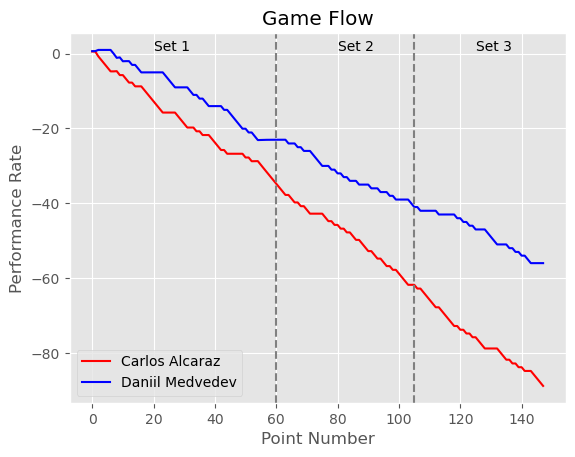

Daniil Medvedev is winning going into set 3 with:  -40.98329524199761 momentum
set 3 prediction is correct


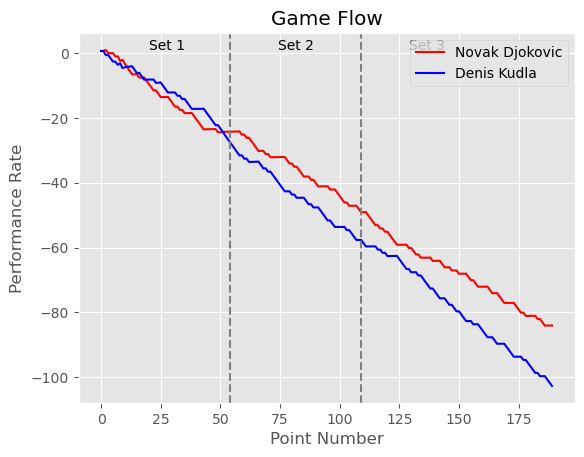

Novak Djokovic is winning going into set 3 with:  -49.10127358317298 momentum
set 3 prediction is correct


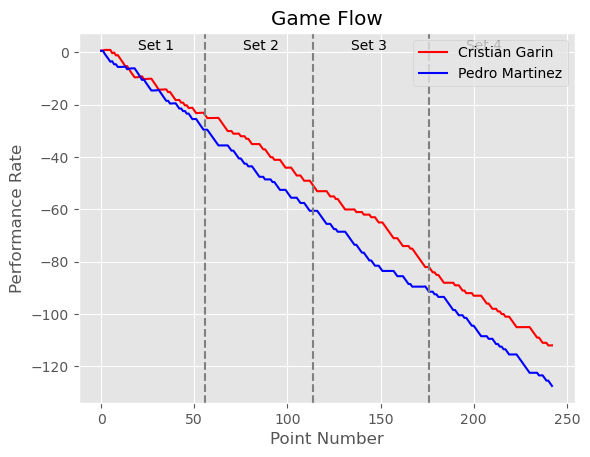

Cristian Garin is winning going into set 3 with:  -51.07156699119183 momentum
Cristian Garin is winning going into set 4 with:  -82.07481350309479 momentum
set 3 prediction is correct
set 4 prediction is correct


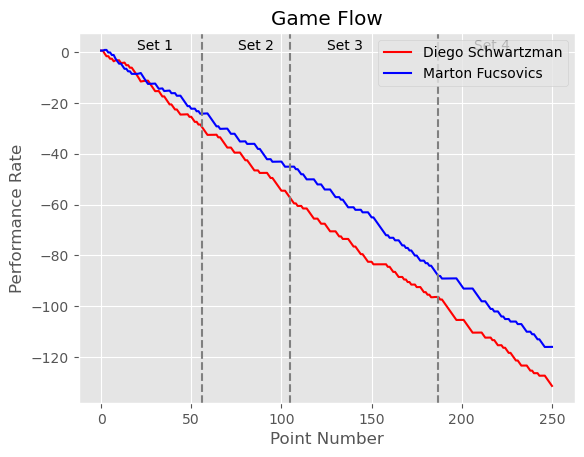

Marton Fucsovics is winning going into set 3 with:  -45.07610000204899 momentum
Marton Fucsovics is winning going into set 4 with:  -88.16819554763613 momentum
set 3 prediction is correct
set 4 prediction is correct


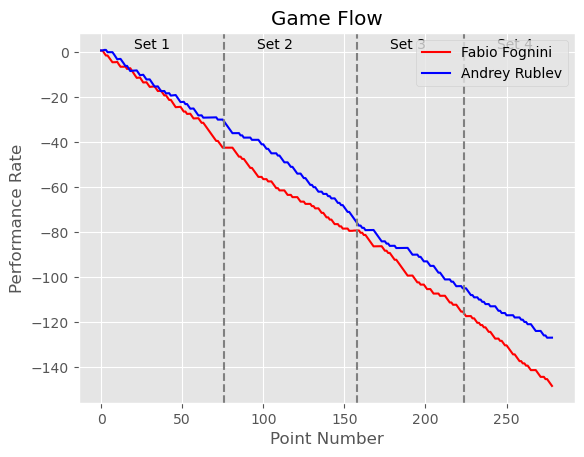

Andrey Rublev is winning going into set 3 with:  -76.19414088255695 momentum
Andrey Rublev is winning going into set 4 with:  -105.09408979537909 momentum
set 3 prediction is correct
set 4 prediction is correct


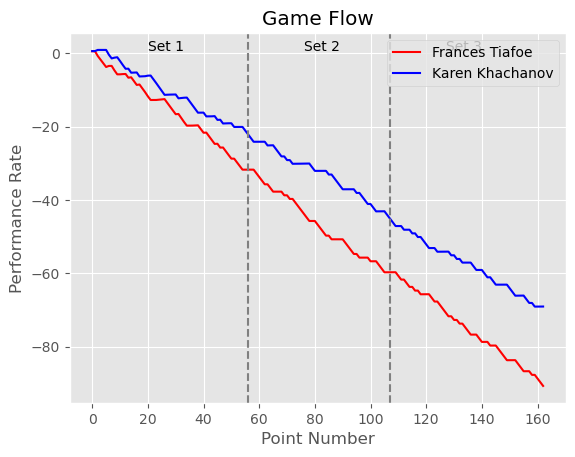

Karen Khachanov is winning going into set 3 with:  -45.07569518212121 momentum
set 3 prediction is correct


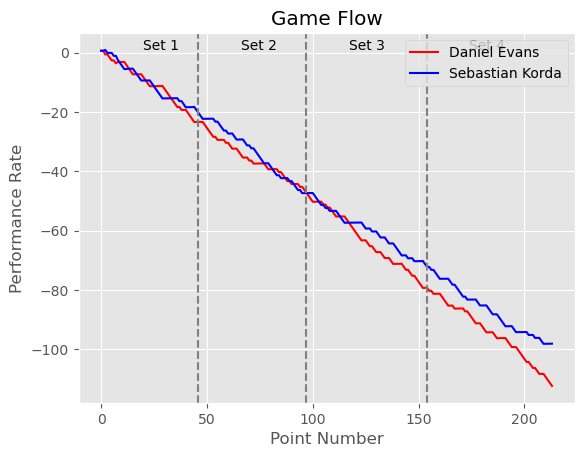

Daniel Evans is winning going into set 3 with:  -47.270217012159165 momentum
Sebastian Korda is winning going into set 4 with:  -72.28539315088634 momentum
set 3 prediction is wrong
set 4 prediction is correct


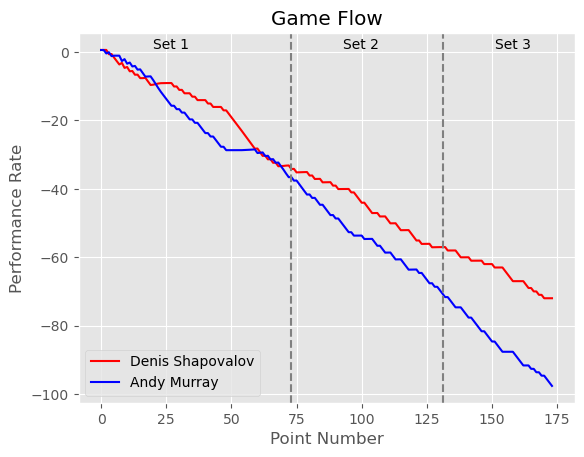

Denis Shapovalov is winning going into set 3 with:  -57.05306335143637 momentum
set 3 prediction is correct


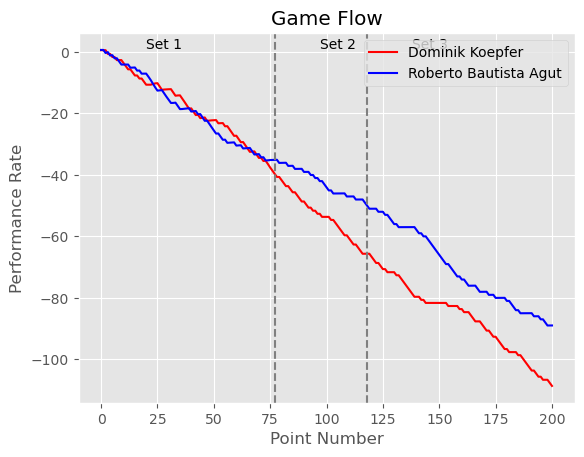

Roberto Bautista Agut is winning going into set 3 with:  -49.99018485866134 momentum
set 3 prediction is correct


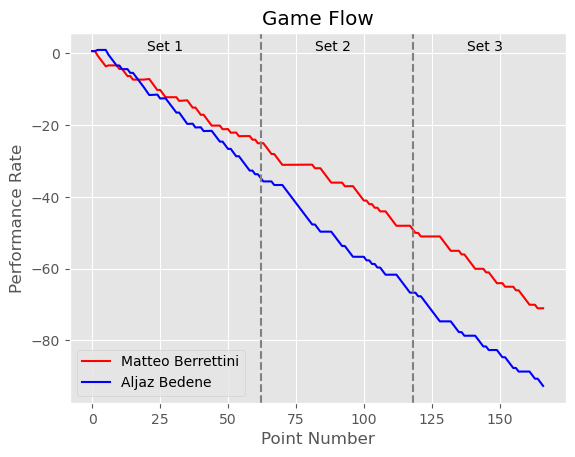

Matteo Berrettini is winning going into set 3 with:  -49.04567185465185 momentum
set 3 prediction is correct


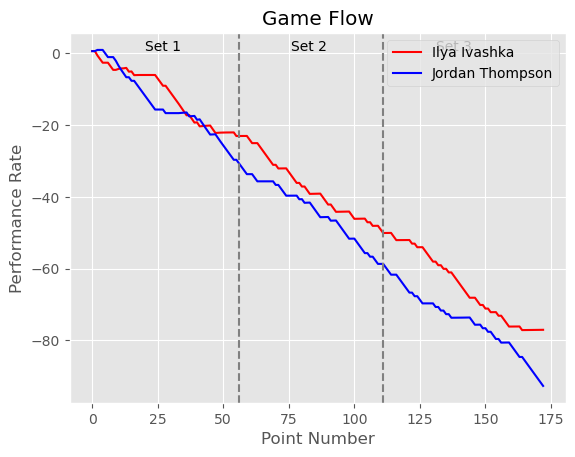

Ilya Ivashka is winning going into set 3 with:  -50.07574653825852 momentum
set 3 prediction is correct


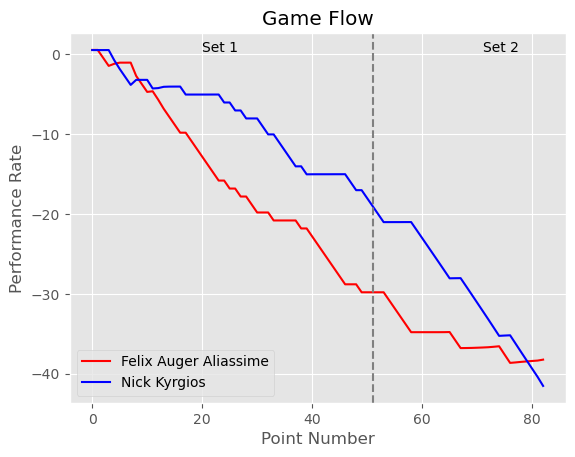

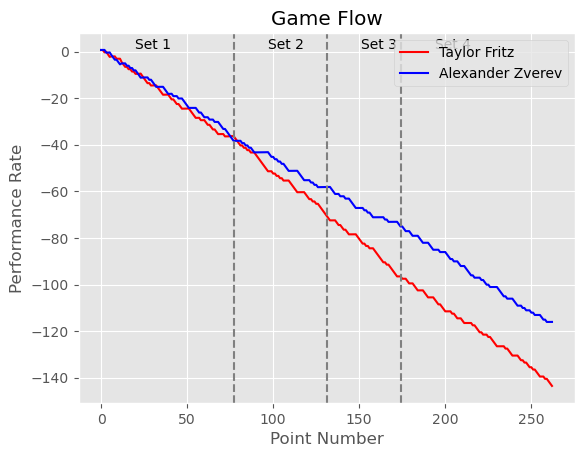

Alexander Zverev is winning going into set 3 with:  -58.1113732108498 momentum
Alexander Zverev is winning going into set 4 with:  -75.07300172333234 momentum
set 3 prediction is correct
set 4 prediction is correct


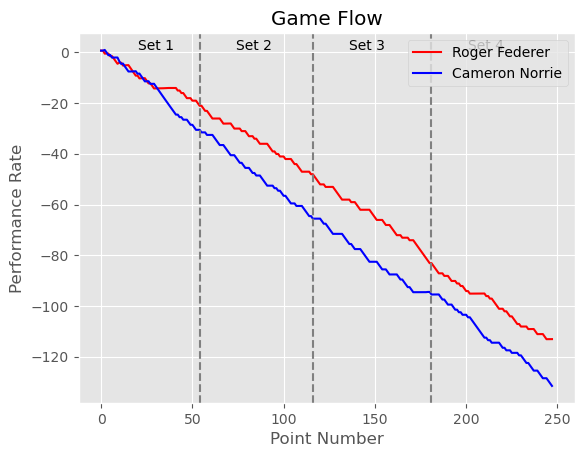

Roger Federer is winning going into set 3 with:  -48.05617987778203 momentum
Roger Federer is winning going into set 4 with:  -83.11616361415201 momentum
set 3 prediction is correct
set 4 prediction is correct


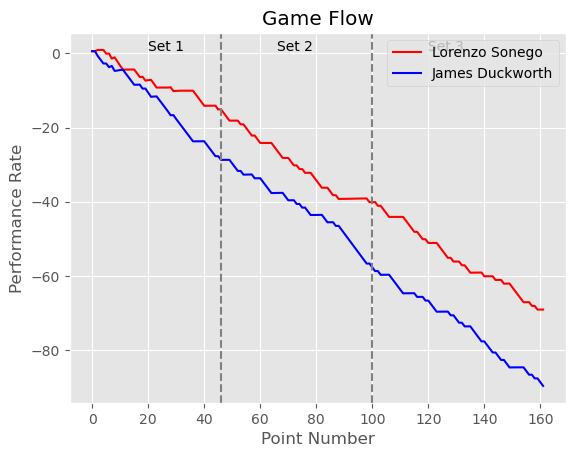

Lorenzo Sonego is winning going into set 3 with:  -40.100406166431625 momentum
set 3 prediction is correct


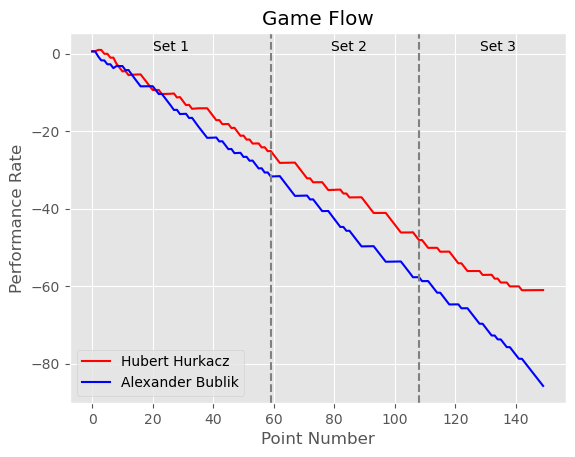

Hubert Hurkacz is winning going into set 3 with:  -48.110271332641055 momentum
set 3 prediction is correct


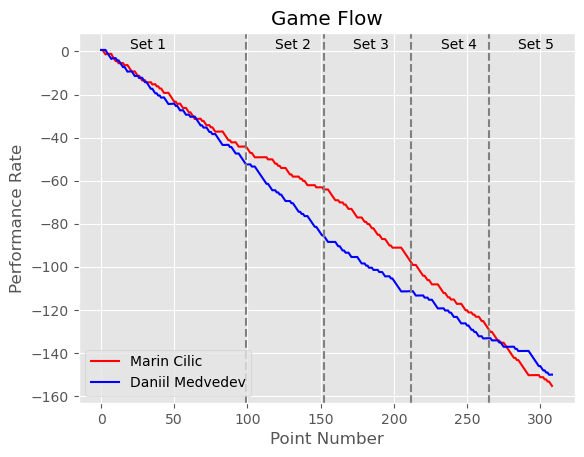

Marin Cilic is winning going into set 3 with:  -64.09666523102824 momentum
Marin Cilic is winning going into set 4 with:  -98.15617217016009 momentum
Marin Cilic is winning going into set 5 with:  -129.2586387837028 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


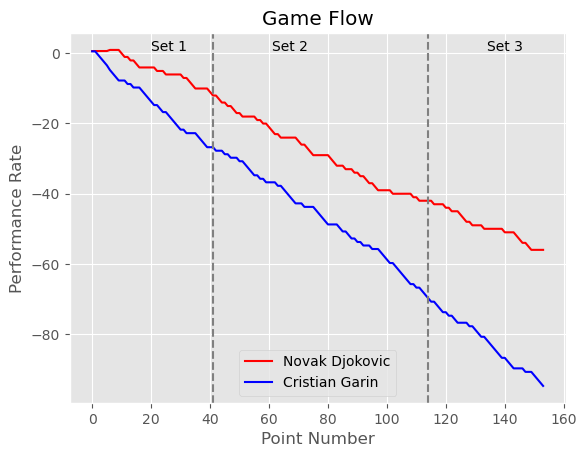

Novak Djokovic is winning going into set 3 with:  -41.99900702386514 momentum
set 3 prediction is correct


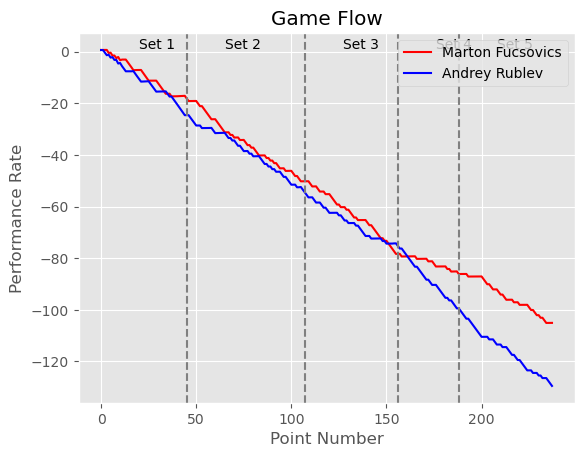

Marton Fucsovics is winning going into set 3 with:  -50.197249083148115 momentum
Andrey Rublev is winning going into set 4 with:  -75.25433559938547 momentum
Marton Fucsovics is winning going into set 5 with:  -86.11997617308886 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is correct


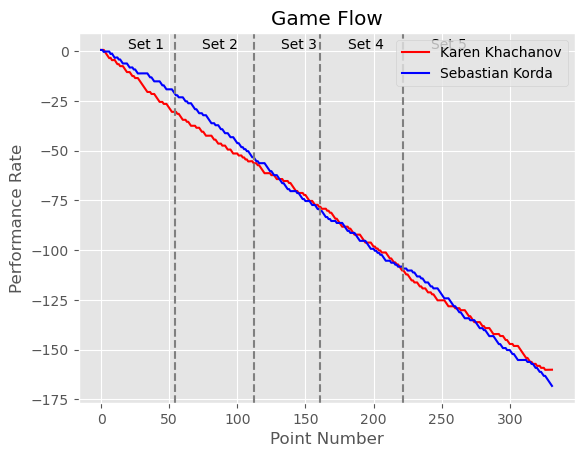

Sebastian Korda is winning going into set 3 with:  -53.25420609961187 momentum
Karen Khachanov is winning going into set 4 with:  -78.18749733556155 momentum
Sebastian Korda is winning going into set 5 with:  -109.24609525081362 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is wrong


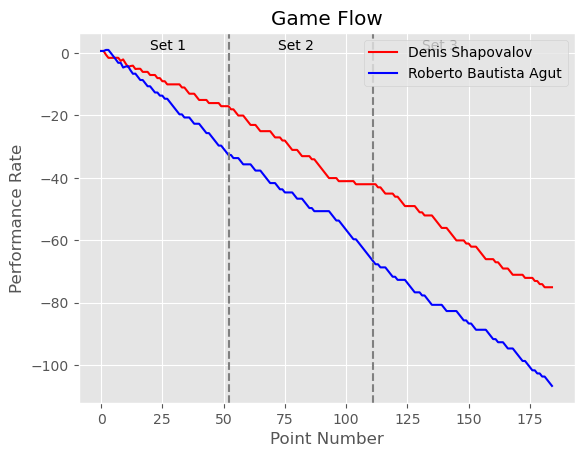

Denis Shapovalov is winning going into set 3 with:  -42.050028303913834 momentum
set 3 prediction is correct


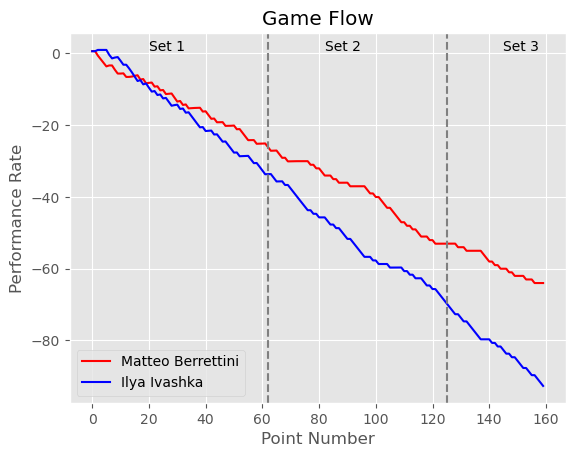

Matteo Berrettini is winning going into set 3 with:  -53.037233745334895 momentum
set 3 prediction is correct


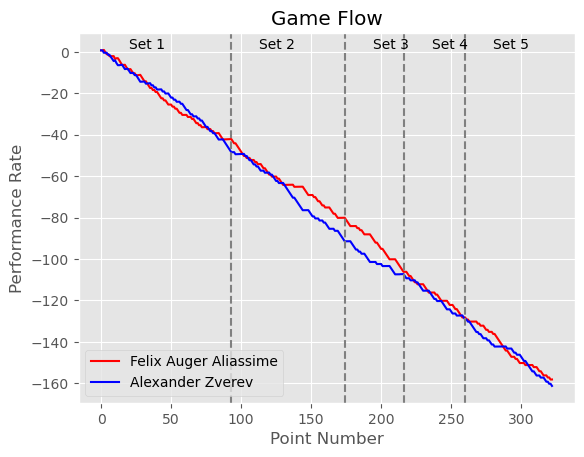

Felix Auger Aliassime is winning going into set 3 with:  -80.0930202546154 momentum
Felix Auger Aliassime is winning going into set 4 with:  -106.19311705798673 momentum
Felix Auger Aliassime is winning going into set 5 with:  -128.21718101761238 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


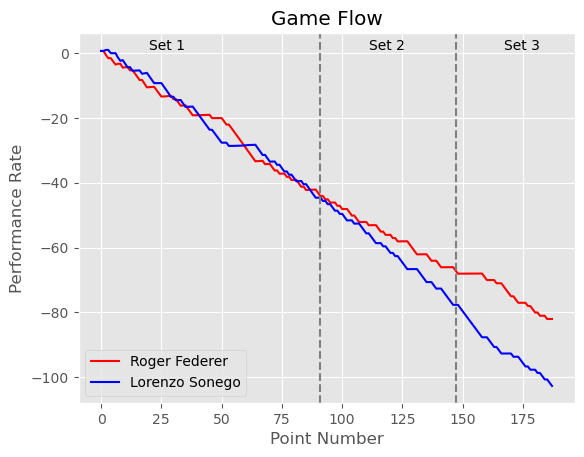

Roger Federer is winning going into set 3 with:  -67.04457153784163 momentum
set 3 prediction is correct


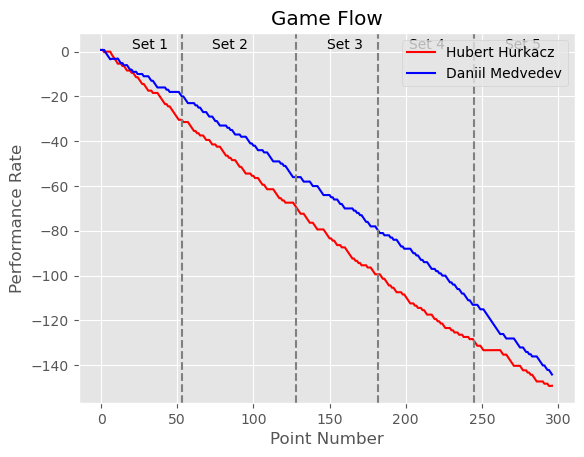

Daniil Medvedev is winning going into set 3 with:  -56.09075043667874 momentum
Daniil Medvedev is winning going into set 4 with:  -80.0582270539415 momentum
Daniil Medvedev is winning going into set 5 with:  -113.08626003564281 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


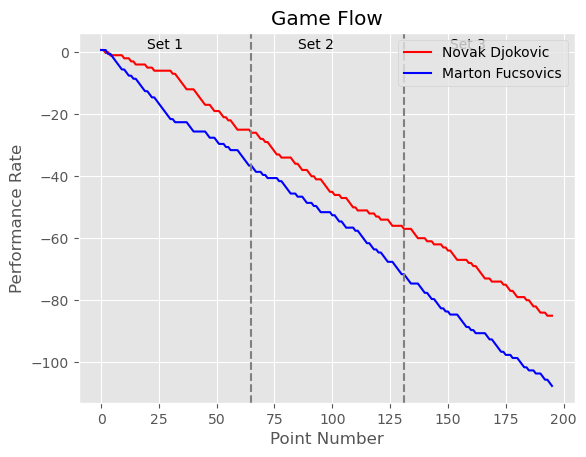

Novak Djokovic is winning going into set 3 with:  -57.03780353293966 momentum
set 3 prediction is correct


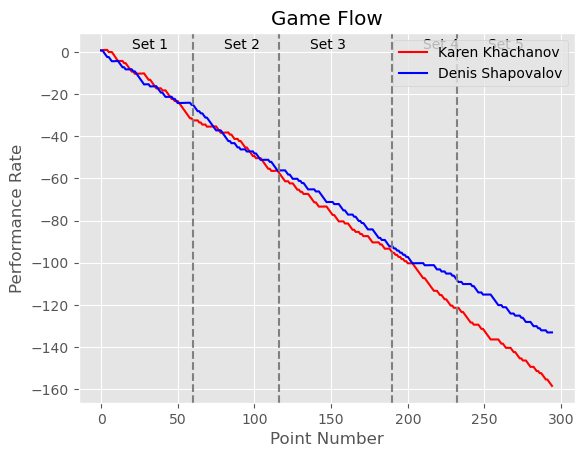

Denis Shapovalov is winning going into set 3 with:  -56.23577515736851 momentum
Denis Shapovalov is winning going into set 4 with:  -92.22592833173123 momentum
Denis Shapovalov is winning going into set 5 with:  -108.11574558634877 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


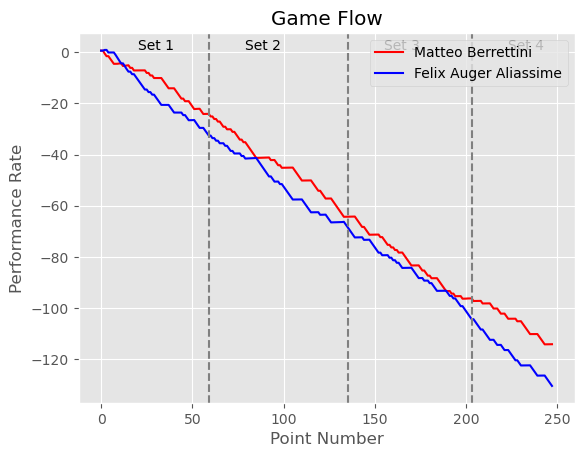

Matteo Berrettini is winning going into set 3 with:  -64.29111006328796 momentum
Matteo Berrettini is winning going into set 4 with:  -96.22011013854366 momentum
set 3 prediction is correct
set 4 prediction is correct


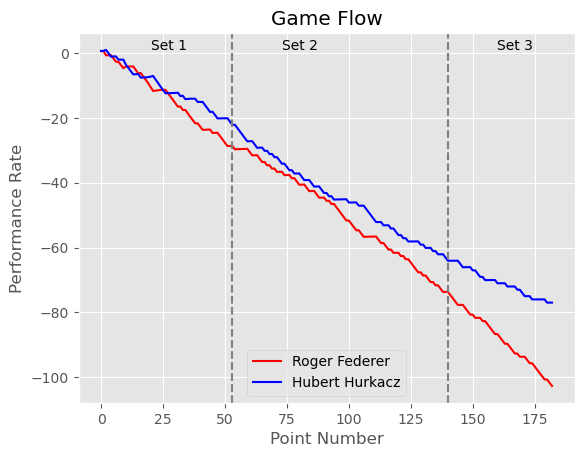

Hubert Hurkacz is winning going into set 3 with:  -64.06894586485228 momentum
set 3 prediction is correct


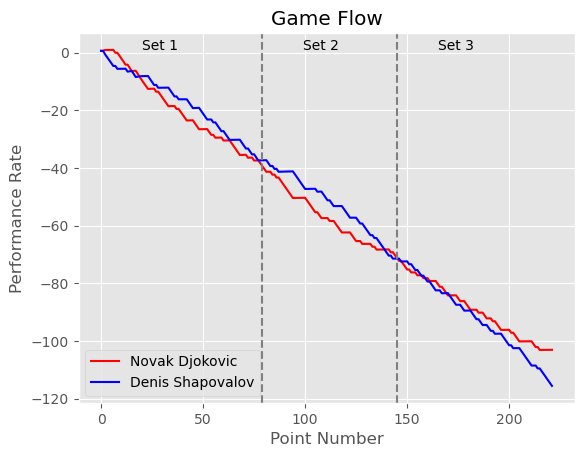

Novak Djokovic is winning going into set 3 with:  -71.18793723394379 momentum
set 3 prediction is correct


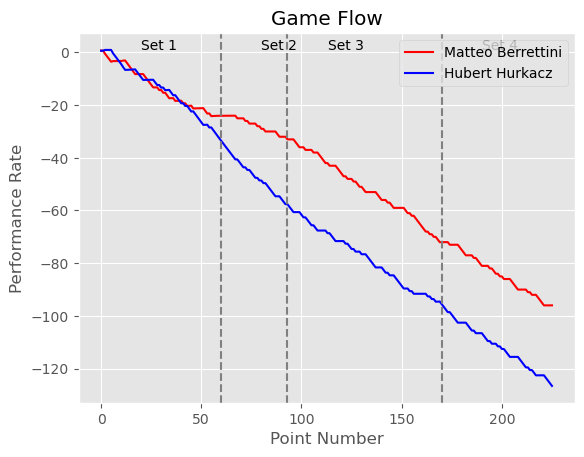

Matteo Berrettini is winning going into set 3 with:  -33.00957846541694 momentum
Matteo Berrettini is winning going into set 4 with:  -72.02533351519165 momentum
set 3 prediction is correct
set 4 prediction is correct


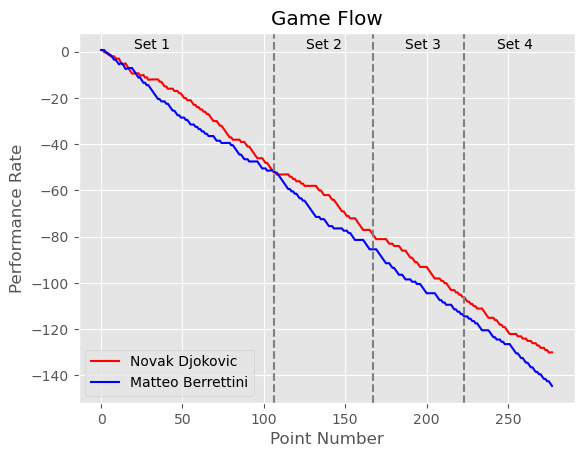

Novak Djokovic is winning going into set 3 with:  -79.06786626706051 momentum
Novak Djokovic is winning going into set 4 with:  -106.06367485196974 momentum
set 3 prediction is correct
set 4 prediction is correct
Predicted winner at set 2 correctly [6] / 125 times
Predicted winner at set 3 correctly [2] / 121 times
Predicted winner at set 4 correctly [3] / 68 times
Predicted winner at set 5 correctly [0] / 25 times


In [107]:
if False:
    FILE = '2023-wimbledon-data.csv'
    # 2023 Matches
    MATCHES_TO_EXAMINE = ['2023-wimbledon-1301', '2023-wimbledon-1302', '2023-wimbledon-1303', '2023-wimbledon-1304', '2023-wimbledon-1305','2023-wimbledon-1306','2023-wimbledon-1307','2023-wimbledon-1308','2023-wimbledon-1309',
                        '2023-wimbledon-1310','2023-wimbledon-1311','2023-wimbledon-1312','2023-wimbledon-1313','2023-wimbledon-1314','2023-wimbledon-1315','2023-wimbledon-1316','2023-wimbledon-1401','2023-wimbledon-1402',
                        '2023-wimbledon-1403','2023-wimbledon-1404','2023-wimbledon-1405','2023-wimbledon-1406','2023-wimbledon-1407','2023-wimbledon-1408','2023-wimbledon-1501','2023-wimbledon-1502','2023-wimbledon-1503',
                        '2023-wimbledon-1504','2023-wimbledon-1601','2023-wimbledon-1602','2023-wimbledon-1701']
if True:
    FILE = '2021-wimbledon-data.csv'
    # 2021 Matches
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1101', '2021-wimbledon-1102', '2021-wimbledon-1103', '2021-wimbledon-1104', '2021-wimbledon-1105',
                        '2021-wimbledon-1106', '2021-wimbledon-1107', '2021-wimbledon-1108', '2021-wimbledon-1109', '2021-wimbledon-1110',
                        '2021-wimbledon-1111', '2021-wimbledon-1112', '2021-wimbledon-1113', '2021-wimbledon-1114', '2021-wimbledon-1115',
                        '2021-wimbledon-1116', '2021-wimbledon-1117', '2021-wimbledon-1118', '2021-wimbledon-1119', '2021-wimbledon-1120',
                        '2021-wimbledon-1121', '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1124', '2021-wimbledon-1125',
                        '2021-wimbledon-1126', '2021-wimbledon-1127', '2021-wimbledon-1128', '2021-wimbledon-1129', '2021-wimbledon-1130',
                        '2021-wimbledon-1131', '2021-wimbledon-1132', '2021-wimbledon-1133', '2021-wimbledon-1134', '2021-wimbledon-1135',
                        '2021-wimbledon-1136', '2021-wimbledon-1137', '2021-wimbledon-1138', '2021-wimbledon-1139', '2021-wimbledon-1140',
                        '2021-wimbledon-1141', '2021-wimbledon-1142', '2021-wimbledon-1143', '2021-wimbledon-1144', '2021-wimbledon-1145',
                        '2021-wimbledon-1146', '2021-wimbledon-1147', '2021-wimbledon-1148', '2021-wimbledon-1150', '2021-wimbledon-1151', 
                        '2021-wimbledon-1152', '2021-wimbledon-1153', '2021-wimbledon-1154', '2021-wimbledon-1155', '2021-wimbledon-1156', 
                        '2021-wimbledon-1157', '2021-wimbledon-1158', '2021-wimbledon-1159', '2021-wimbledon-1160', '2021-wimbledon-1161', 
                        '2021-wimbledon-1162', '2021-wimbledon-1163', '2021-wimbledon-1164', '2021-wimbledon-1201', '2021-wimbledon-1202', 
                        '2021-wimbledon-1203', '2021-wimbledon-1204', '2021-wimbledon-1205', '2021-wimbledon-1206', '2021-wimbledon-1207', 
                        '2021-wimbledon-1208', '2021-wimbledon-1209', '2021-wimbledon-1210', '2021-wimbledon-1211', '2021-wimbledon-1212', 
                        '2021-wimbledon-1214', '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1217', '2021-wimbledon-1218', 
                        '2021-wimbledon-1219', '2021-wimbledon-1220', '2021-wimbledon-1221', '2021-wimbledon-1222', '2021-wimbledon-1223', 
                        '2021-wimbledon-1224', '2021-wimbledon-1225', '2021-wimbledon-1226', '2021-wimbledon-1227', '2021-wimbledon-1228', 
                        '2021-wimbledon-1229', '2021-wimbledon-1230', '2021-wimbledon-1231', '2021-wimbledon-1232', '2021-wimbledon-1301', 
                        '2021-wimbledon-1302', '2021-wimbledon-1303', '2021-wimbledon-1304', '2021-wimbledon-1305', '2021-wimbledon-1306', 
                        '2021-wimbledon-1307', '2021-wimbledon-1308', '2021-wimbledon-1309', '2021-wimbledon-1310', '2021-wimbledon-1311', 
                        '2021-wimbledon-1312', '2021-wimbledon-1313', '2021-wimbledon-1314', '2021-wimbledon-1315', '2021-wimbledon-1316', 
                        '2021-wimbledon-1401', '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1404', '2021-wimbledon-1405', 
                        '2021-wimbledon-1406', '2021-wimbledon-1407', '2021-wimbledon-1408', '2021-wimbledon-1501', '2021-wimbledon-1502', 
                        '2021-wimbledon-1503', '2021-wimbledon-1504', '2021-wimbledon-1601', '2021-wimbledon-1602', '2021-wimbledon-1701']

if False:
    FILE = '2021-wimbledon-data.csv'
    # 2021 matches of 5 sets
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1104', '2021-wimbledon-1105', '2021-wimbledon-1107', '2021-wimbledon-1108', 
                        '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1125', '2021-wimbledon-1126', 
                        '2021-wimbledon-1127', '2021-wimbledon-1136', '2021-wimbledon-1140', '2021-wimbledon-1142', 
                        '2021-wimbledon-1144', '2021-wimbledon-1158', '2021-wimbledon-1163', '2021-wimbledon-1214',
                        '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1223', '2021-wimbledon-1316', 
                        '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1406', '2021-wimbledon-1408', 
                        '2021-wimbledon-1502']

set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0

for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
    model = MarkovChain(FILE, MATCH_TO_EXAMINE)
    model.train()
    model.graph_momentum()
    result_array = model.prediction()

    try:
        set1_correct += result_array[0]
        set1_total += 1

        set2_correct += result_array[1]
        set2_total += 1

        set3_correct += result_array[2]
        set3_total += 1

        set4_correct += result_array[3]
        set4_total += 1
    finally:
        continue

print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")